# galah_dr4_grid_interpolation_trainingset_creation

In [1]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
import os
import pickle
from astropy.table import Table
from scipy.io import readsav
from scipy.ndimage.filters import convolve
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import time

In [2]:
# Read in all available grids
grids = Table.read('../spectrum_grids/galah_dr4_model_trainingset_gridpoints.fits')

In [3]:
# choose one grid_index
try:
    grid_index = int(sys.argv[1])
    print('Using Grid index ',grid_index)
except:
    print('Interactive mode')
    grid_index = 1931
    print('Using Grid index ',grid_index)

Interactive mode
Using Grid index  1931


In [4]:
try:
    teff_logg_feh_name = str(int(grids['teff_subgrid'][grid_index]))+'_'+"{:.2f}".format(grids['logg_subgrid'][grid_index])+'_'+"{:.2f}".format(grids['fe_h_subgrid'][grid_index])
    training_set_vsini0 = Table.read('../spectrum_grids/3d_bin_subgrids/'+teff_logg_feh_name+'/galah_dr4_trainingset_'+teff_logg_feh_name+'.fits')
    synthesis_files = '../spectrum_grids/3d_bin_subgrids/'+teff_logg_feh_name
    print('Grid index '+str(grid_index)+' corresponds to '+teff_logg_feh_name)
except:
    raise ValueError('There are only '+str(len(grids))+' entries within the grid')

Grid index 1931 corresponds to 5750_4.50_0.00


### Below we define how to broaden a spectrum with a certain vsini value

In [5]:
def integrate_flux(mu, inten, deltav, vsini, vrt, osamp=1):
    """
    Produces a flux profile by integrating intensity profiles (sampled
    at various mu angles) over the visible stellar surface.
    Intensity profiles are weighted by the fraction of the projected
    stellar surface they represent, apportioning the area between
    adjacent MU points equally. Additional weights (such as those
    used in a Gauss-Legendre quadrature) can not meaningfully be
    used in this scheme.  About twice as many points are required
    with this scheme to achieve the precision of Gauss-Legendre
    quadrature.
    DELTAV, VSINI, and VRT must all be in the same units (e.g. km/s).
    If specified, OSAMP should be a positive integer.
    Parameters
    ----------
    mu : array(float) of size (nmu,)
        cosine of the angle between the outward normal and
        the line of sight for each intensity spectrum in INTEN.
    inten : array(float) of size(nmu, npts)
        intensity spectra at specified values of MU.
    deltav : float
        velocity spacing between adjacent spectrum points
        in INTEN (same units as VSINI and VRT).
    vsini : float
        maximum radial velocity, due to solid-body rotation.
    vrt : float
        radial-tangential macroturbulence parameter, i.e.
        np.sqrt(2) times the standard deviation of a Gaussian distribution
        of turbulent velocities. The same distribution function describes
        the radial motions of one component and the tangential motions of
        a second component. Each component covers half the stellar surface.
        See 'The Observation and Analysis of Stellar Photospheres', Gray.
    osamp : int, optional
        internal oversampling factor for convolutions.
        By default convolutions are done using the input points (OSAMP=1),
        but when OSAMP is set to higher integer values, the input spectra
        are first oversampled by cubic spline interpolation.
    Returns
    -------
    value : array(float) of size (npts,)
        Disk integrated flux profile.
    Note
    ------------
        If you use this algorithm in work that you publish, please cite
        Valenti & Anderson 1996, PASP, currently in preparation.
    """
    """
    History
    -----------
    Feb-88  GM
        Created ANA version.
    13-Oct-92 JAV
        Adapted from G. Marcy's ANA routi!= of the same name.
    03-Nov-93 JAV
        Switched to annular convolution technique.
    12-Nov-93 JAV
        Fixed bug. Intensity compo!=nts not added when vsini=0.
    14-Jun-94 JAV
        Reformatted for "public" release. Heavily commented.
        Pass deltav instead of 2.998d5/deltav. Added osamp
        keyword. Added rebinning logic at end of routine.
        Changed default osamp from 3 to 1.
    20-Feb-95 JAV
        Added mu as an argument to handle arbitrary mu sampling
        and remove ambiguity in intensity profile ordering.
        Interpret VTURB as np.sqrt(2)*sigma instead of just sigma.
        Replaced call_external with call to spl_{init|interp}.
    03-Apr-95 JAV
        Multiply flux by pi to give observed flux.
    24-Oct-95 JAV
        Force "nmk" padding to be at least 3 pixels.
    18-Dec-95 JAV
        Renamed from dskint() to rtint(). No longer make local
        copy of intensities. Use radial-tangential instead
        of isotropic Gaussian macroturbulence.
    26-Jan-99 JAV
        For NMU=1 and VSINI=0, assume resolved solar surface#
        apply R-T macro, but supress vsini broadening.
    01-Apr-99 GMH
        Use annuli weights, rather than assuming ==ual area.
    07-Mar-12 JAV
        Force vsini and vmac to be scalars.
    """

    # Make local copies of various input variables, which will be altered below.
    # Force vsini and especially vmac to be scalars. Otherwise mu dependence fails.

    if np.size(vsini) > 1:
        vsini = vsini[0]
    if np.size(vrt) > 1:
        vrt = vrt[0]

    # Determine oversampling factor.
    os = round(np.clip(osamp, 1, None))  # force integral value > 1

    # Convert input MU to projected radii, R, of annuli for a star of unit radius
    #  (which is just sine, rather than cosine, of the angle between the outward
    #  normal and the line of sight).
    rmu = np.sqrt(1 - mu ** 2)  # use simple trig identity

    # Sort the projected radii and corresponding intensity spectra into ascending
    #  order (i.e. from disk center to the limb), which is equivalent to sorting
    #  MU in descending order.
    isort = np.argsort(rmu)
    rmu = rmu[isort]  # reorder projected radii
    nmu = np.size(mu)  # number of radii
    if nmu == 1:
        if vsini != 0:
            logger.warning(
                "Vsini is non-zero, but only one projected radius (mu value) is set. No rotational broadening will be performed."
            )
            vsini = 0  # ignore vsini if only 1 mu

    # Calculate projected radii for boundaries of disk integration annuli.  The n+1
    # boundaries are selected such that r(i+1) exactly bisects the area between
    # rmu(i) and rmu(i+1). The in!=rmost boundary, r(0) is set to 0 (disk center)
    # and the outermost boundary, r(nmu) is set to 1 (limb).
    if nmu > 1 or vsini != 0:  # really want disk integration
        r = np.sqrt(
            0.5 * (rmu[:-1] ** 2 + rmu[1:] ** 2)
        )  # area midpoints between rmu
        r = np.concatenate(([0], r, [1]))

        # Calculate integration weights for each disk integration annulus.  The weight
        # is just given by the relative area of each annulus, normalized such that
        # the sum of all weights is unity.  Weights for limb darkening are included
        # explicitly in the intensity profiles, so they aren't needed here.
        wt = r[1:] ** 2 - r[:-1] ** 2  # weights = relative areas
    else:
        wt = np.array([1.0])  # single mu value, full weight

    # Generate index vectors for input and oversampled points. Note that the
    # oversampled indicies are carefully chosen such that every "os" finely
    # sampled points fit exactly into one input bin. This makes it simple to
    # "integrate" the finely sampled points at the end of the routine.
    npts = inten.shape[1]  # number of points
    xpix = np.arange(npts, dtype=float)  # point indices
    nfine = os * npts  # number of oversampled points
    xfine = (0.5 / os) * (
        2 * np.arange(nfine, dtype=float) - os + 1
    )  # oversampled points indices

    # Loop through annuli, constructing and convolving with rotation kernels.

    yfine = np.empty(nfine)  # init oversampled intensities
    flux = np.zeros(nfine)  # init flux vector
    for imu in range(nmu):  # loop thru integration annuli

        #  Use external cubic spline routine (adapted from Numerical Recipes) to make
        #  an oversampled version of the intensity profile for the current annulus.
        ypix = inten[isort[imu]]  # extract intensity profile
        if os == 1:
            # just copy (use) original profile
            yfine = ypix
        else:
            # spline onto fine wavelength scale
            yfine = interp1d(xpix, ypix, kind="cubic")(xfine)

        # Construct the convolution kernel which describes the distribution of
        # rotational velocities present in the current annulus. The distribution has
        # been derived analytically for annuli of arbitrary thickness in a rigidly
        # rotating star. The kernel is constructed in two pieces: o!= piece for
        # radial velocities less than the maximum velocity along the inner edge of
        # the annulus, and one piece for velocities greater than this limit.
        if vsini > 0:
            # nontrivial case
            r1 = r[imu]  # inner edge of annulus
            r2 = r[imu + 1]  # outer edge of annulus
            dv = deltav / os  # oversampled velocity spacing
            maxv = vsini * r2  # maximum velocity in annulus
            nrk = 2 * int(maxv / dv) + 3  ## oversampled kernel point
            # velocity scale for kernel
            v = dv * (np.arange(nrk, dtype=float) - ((nrk - 1) / 2))
            rkern = np.zeros(nrk)  # init rotational kernel
            j1 = np.abs(v) < vsini * r1  # low velocity points
            rkern[j1] = np.sqrt((vsini * r2) ** 2 - v[j1] ** 2) - np.sqrt(
                (vsini * r1) ** 2 - v[j1] ** 2
            )  # generate distribution

            j2 = (np.abs(v) >= vsini * r1) & (np.abs(v) <= vsini * r2)
            rkern[j2] = np.sqrt(
                (vsini * r2) ** 2 - v[j2] ** 2
            )  # generate distribution

            rkern = rkern / np.sum(rkern)  # normalize kernel

            # Convolve the intensity profile with the rotational velocity kernel for this
            # annulus. Pad each end of the profile with as many points as are in the
            # convolution kernel. This reduces Fourier ringing. The convolution may also
            # be do!= with a routi!= called "externally" from IDL, which efficiently
            # shifts and adds.
            if nrk > 3:
                yfine = convolve(yfine, rkern, mode="nearest")

        # Calculate projected sigma for radial and tangential velocity distributions.
        muval = mu[isort[imu]]  # current value of mu
        sigma = os * vrt / np.sqrt(2) / deltav  # standard deviation in points
        sigr = sigma * muval  # reduce by current mu value
        sigt = sigma * np.sqrt(1.0 - muval ** 2)  # reduce by np.sqrt(1-mu**2)

        # Figure out how many points to use in macroturbulence kernel.
        nmk = int(10 * sigma)
        nmk = np.clip(nmk, 3, (nfine - 3) // 2)

        # Construct radial macroturbulence kernel with a sigma of mu*VRT/np.sqrt(2).
        if sigr > 0:
            xarg = np.linspace(-nmk, nmk, 2 * nmk + 1) / sigr
            xarg = np.clip(-0.5 * xarg ** 2, -20, None)
            mrkern = np.exp(xarg)  # compute the gaussian
            mrkern = mrkern / np.sum(mrkern)  # normalize the profile
        else:
            mrkern = np.zeros(2 * nmk + 1)  # init with 0d0
            mrkern[nmk] = 1.0  # delta function

        # Construct tangential kernel with a sigma of np.sqrt(1-mu**2)*VRT/np.sqrt(2).
        if sigt > 0:
            xarg = np.linspace(-nmk, nmk, 2 * nmk + 1) / sigt
            xarg = np.clip(-0.5 * xarg ** 2, -20, None)
            mtkern = np.exp(xarg)  # compute the gaussian
            mtkern = mtkern / np.sum(mtkern)  # normalize the profile
        else:
            mtkern = np.zeros(2 * nmk + 1)  # init with 0d0
            mtkern[nmk] = 1.0  # delta function

        # Sum the radial and tangential components, weighted by surface area.
        area_r = 0.5  # assume equal areas
        area_t = 0.5  # ar+at must equal 1
        mkern = area_r * mrkern + area_t * mtkern  # add both components

        # Convolve the total flux profiles, again padding the spectrum on both ends to
        # protect against Fourier ringing.
        yfine = convolve(
            yfine, mkern, mode="nearest"
        )  # add the padding and convolve

        # Add contribution from current annulus to the running total.
        flux = flux + wt[imu] * yfine  # add profile to running total

    flux = np.reshape(flux, (npts, os))  # convert to an array
    flux = np.pi * np.sum(flux, axis=1) / os  # sum, normalize
    return flux

In [6]:
def broaden_spectrum(wint_seg, sint_seg, wave_seg, cmod_seg, vsini=0, vmac=0, debug=False):

    nw = len(wint_seg)
    clight = 299792.5
    mu = (np.sqrt(0.5*(2*np.arange(7)+1)/np.float(7)))[::-1]
    nmu = 7
    wmid = 0.5 * (wint_seg[nw-1] + wint_seg[0])
    wspan = wint_seg[nw-1] - wint_seg[0]
    jmin = np.argmin(wint_seg[1:nw-1] - wint_seg[0:nw-2])
    vstep1 = min(wint_seg[1:nw-1] - wint_seg[0:nw-2])
    vstep2 = 0.1 * wspan / (nw-1) / wmid * clight
    vstep3 = 0.05
    vstep = np.max([vstep1,vstep2,vstep3])

    # Generate model wavelength scale X, with uniform wavelength step.
    nx = int(np.floor(np.log10(wint_seg[nw-1] / wint_seg[0])/ np.log10(1.0+vstep / clight))+1)
    if nx % 2 == 0: nx += 1
    resol_out = 1.0/((wint_seg[nw-1] / wint_seg[0])**(1.0/(nx-1.0))-1.0)
    vstep = clight / resol_out
    x_seg = wint_seg[0] * (1.0 + 1.0 / resol_out)**np.arange(nx)

    # Interpolate intensity spectra onto new model wavelength scale.  
    yi_seg = np.empty((nmu, nx))

    for imu in range(nmu):
        yi_seg[imu] = np.interp(x_seg, wint_seg, sint_seg[imu])

    y_seg = integrate_flux(mu, yi_seg, vstep, np.abs(vsini), np.abs(vmac))

    dispersion = vstep1
    wave_equi = np.arange(x_seg[0],x_seg[-1]+dispersion,dispersion)

    c_seg = np.interp(wave_equi,wave_seg,cmod_seg)
    y_seg = np.interp(wave_equi,x_seg,y_seg)

    if debug:
        print(vstep1,len(wave_equi))

    return(wave_equi,y_seg/c_seg)

In [7]:
vsini_values = np.array([1.5, 3.0, 6.0, 9.0, 12.0, 18.0]) # km/s
if grids['teff_subgrid'][grid_index] >= 5000:
    vsini_values = np.array([1.5, 3.0, 6.0, 9.0, 12.0, 18.0, 24.0]) # km/s
if grids['teff_subgrid'][grid_index] >= 6000:
    vsini_values = np.array([1.5, 3.0, 6.0, 9.0, 12.0, 18.0, 24.0, 36.0]) # km/s

# Gradient Spectra and Masks

In [8]:
null_spectrum_broad = dict()
for ccd in [1,2,3,4]:
    null_spectrum = readsav(synthesis_files+'/galah_dr4_trainingset_'+teff_logg_feh_name+'_0_'+str(ccd)+'.out').results[0]
    null_spectrum_broad['wave_null_ccd'+str(ccd)],null_spectrum_broad['spectrum_null_ccd'+str(ccd)] = broaden_spectrum(
            null_spectrum.wint,
            null_spectrum.sint,
            null_spectrum.wave,
            null_spectrum.cmod,
            vsini = vsini_values[-1]
        )
print('The synthetic spectra come with keywords ',null_spectrum.dtype.names)

The synthetic spectra come with keywords  ('WAVE', 'SMOD', 'CMOD', 'WINT', 'SINT')


In [9]:
labels = np.array(training_set_vsini0.keys()[2:-1])
labels

array(['teff', 'logg', 'fe_h', 'vmic', 'li_fe', 'c_fe', 'n_fe', 'o_fe',
       'na_fe', 'mg_fe', 'al_fe', 'si_fe', 'k_fe', 'ca_fe', 'sc_fe',
       'ti_fe', 'v_fe', 'cr_fe', 'mn_fe', 'co_fe', 'ni_fe', 'cu_fe',
       'zn_fe', 'rb_fe', 'sr_fe', 'y_fe', 'zr_fe', 'mo_fe', 'ru_fe',
       'ba_fe', 'la_fe', 'ce_fe', 'nd_fe', 'sm_fe', 'eu_fe'], dtype='<U5')

In [10]:
fancy_labels = []
for label in labels:
    if label == 'teff':
        fancy_labels.append(r'$T_\mathrm{eff}~/~\mathrm{K}$')
    elif label == 'logg':
        fancy_labels.append(r'$\log (g~/~\mathrm{cm\,s^{-2}})$')
    elif label == 'fe_h':
        fancy_labels.append(r'$\mathrm{[Fe/H]}$')
    elif label == 'vmic':
        fancy_labels.append(r'$v_\mathrm{mic}~/~\mathrm{km\,s^{-1}}$')
    elif label == 'vsini':
        fancy_labels.append(r'$v \sin i~/~\mathrm{km\,s^{-1}}$')
    elif label[-3:] == '_fe':
        fancy_labels.append('$\mathrm{['+label[0].upper()+label[1:-3]+'/Fe]}$')
    else:
        print('No entry for '+label)
print(fancy_labels)

['$T_\\mathrm{eff}~/~\\mathrm{K}$', '$\\log (g~/~\\mathrm{cm\\,s^{-2}})$', '$\\mathrm{[Fe/H]}$', '$v_\\mathrm{mic}~/~\\mathrm{km\\,s^{-1}}$', '$\\mathrm{[Li/Fe]}$', '$\\mathrm{[C/Fe]}$', '$\\mathrm{[N/Fe]}$', '$\\mathrm{[O/Fe]}$', '$\\mathrm{[Na/Fe]}$', '$\\mathrm{[Mg/Fe]}$', '$\\mathrm{[Al/Fe]}$', '$\\mathrm{[Si/Fe]}$', '$\\mathrm{[K/Fe]}$', '$\\mathrm{[Ca/Fe]}$', '$\\mathrm{[Sc/Fe]}$', '$\\mathrm{[Ti/Fe]}$', '$\\mathrm{[V/Fe]}$', '$\\mathrm{[Cr/Fe]}$', '$\\mathrm{[Mn/Fe]}$', '$\\mathrm{[Co/Fe]}$', '$\\mathrm{[Ni/Fe]}$', '$\\mathrm{[Cu/Fe]}$', '$\\mathrm{[Zn/Fe]}$', '$\\mathrm{[Rb/Fe]}$', '$\\mathrm{[Sr/Fe]}$', '$\\mathrm{[Y/Fe]}$', '$\\mathrm{[Zr/Fe]}$', '$\\mathrm{[Mo/Fe]}$', '$\\mathrm{[Ru/Fe]}$', '$\\mathrm{[Ba/Fe]}$', '$\\mathrm{[La/Fe]}$', '$\\mathrm{[Ce/Fe]}$', '$\\mathrm{[Nd/Fe]}$', '$\\mathrm{[Sm/Fe]}$', '$\\mathrm{[Eu/Fe]}$']


In [11]:
gradient_spectra_up = Table()
gradient_spectra_up['wave'] = np.concatenate(([null_spectrum_broad['wave_null_ccd'+str(ccd)] for ccd in [1,2,3,4]]))
gradient_spectra_up['median'] = np.concatenate(([null_spectrum_broad['spectrum_null_ccd'+str(ccd)] for ccd in [1,2,3,4]]))

gradient_spectra_down = Table()
gradient_spectra_down['wave'] = np.concatenate(([null_spectrum_broad['wave_null_ccd'+str(ccd)] for ccd in [1,2,3,4]]))
gradient_spectra_down['median'] = np.concatenate(([null_spectrum_broad['spectrum_null_ccd'+str(ccd)] for ccd in [1,2,3,4]]))

In [12]:
for label_index, label in enumerate(labels):
    
    gradient_up = []
    gradient_down = []
    
    for ccd in [1,2,3,4]:
        spectra_available = False
        try:
            increased_spectrum = readsav(synthesis_files+'/galah_dr4_trainingset_'+teff_logg_feh_name+'_'+str(2+label_index)+'_'+str(ccd)+'.out').results[0]
            decreased_spectrum = readsav(synthesis_files+'/galah_dr4_trainingset_'+teff_logg_feh_name+'_'+str(37+label_index)+'_'+str(ccd)+'.out').results[0]
            spectra_available = True
        except:
            try:
                increased_spectrum = readsav(synthesis_files+'/galah_dr4_cannon_trainingset_'+teff_logg_feh_name+'_'+str(2+label_index)+'_'+str(ccd)+'.out').results[0]
                decreased_spectrum = readsav(synthesis_files+'/galah_dr4_cannon_trainingset_'+teff_logg_feh_name+'_'+str(37+label_index)+'_'+str(ccd)+'.out').results[0]
                spectra_available = True
            except:
                pass
            
        if spectra_available:
            wave_increase, spectrum_increase = broaden_spectrum(
                increased_spectrum.wint,
                increased_spectrum.sint,
                increased_spectrum.wave,
                increased_spectrum.cmod,
                vsini = vsini_values[-1]
            )

            wave_decrease, spectrum_decrease = broaden_spectrum(
                decreased_spectrum.wint,
                decreased_spectrum.sint,
                decreased_spectrum.wave,
                decreased_spectrum.cmod,
                vsini = vsini_values[-1]
            )

            gradient_up.append(spectrum_increase - null_spectrum_broad['spectrum_null_ccd'+str(ccd)])
            gradient_down.append(spectrum_decrease - null_spectrum_broad['spectrum_null_ccd'+str(ccd)])
        else:
            if label == 'teff':
                print('No gradient spectrum for Teff available (possible for grid edges e.g. 8000K) - fixing by returning 1s')
                gradient_up.append(np.ones(len(null_spectrum_broad['wave_null_ccd'+str(ccd)])))
                gradient_down.append(-np.ones(len(null_spectrum_broad['wave_null_ccd'+str(ccd)])))
            
            elif label == 'logg':
                print('No gradient spectrum for logg available (possible for grid edges e.g. 5.0) - fixing by returning 1s')
                gradient_up.append(np.ones(len(null_spectrum_broad['wave_null_ccd'+str(ccd)])))
                gradient_down.append(-np.ones(len(null_spectrum_broad['wave_null_ccd'+str(ccd)])))
            
            elif label == 'o_fe':
                print('No gradient spectrum for ofe available (possible for cool stars) - fixing by returning 1s')
                gradient_up.append(np.ones(len(null_spectrum_broad['wave_null_ccd'+str(ccd)])))
                gradient_down.append(-np.ones(len(null_spectrum_broad['wave_null_ccd'+str(ccd)])))
            
            else:
                print(label)
            
    gradient_spectra_up[label] = np.concatenate((gradient_up))
    gradient_spectra_down[label] = np.concatenate((gradient_down))

In [13]:
h_beta = (gradient_spectra_up['wave'] >= 4860.90 - 1) & (gradient_spectra_up['wave'] <= 4861.77 + 1)
h_alpha = (gradient_spectra_up['wave'] >= 6562.00 - 1) & (gradient_spectra_up['wave'] <= 6563.60 + 1)
usual_galah_wavelength_range = (
    ((gradient_spectra_up['wave'] > 4710) & (gradient_spectra_up['wave'] < 4905)) |
    ((gradient_spectra_up['wave'] > 5645) & (gradient_spectra_up['wave'] < 5880)) |
    ((gradient_spectra_up['wave'] > 6470) & (gradient_spectra_up['wave'] < 6750)) |
    ((gradient_spectra_up['wave'] > 7670) & (gradient_spectra_up['wave'] < 7900))
)
usual_galah_range_without_balmer_cores = (~h_beta) & (~h_alpha) & usual_galah_wavelength_range

total = len(gradient_spectra_up)
total_usual = len(gradient_spectra_up[usual_galah_range_without_balmer_cores])
print('Total points: '+str(total)+', within GALAH range (exluding Balmer cores): '+str(total_usual))


Total points: 64224, within GALAH range (exluding Balmer cores): 46918


teff 250.0
0.0001:    99.8% 46827
0.001:    85.3% 39998


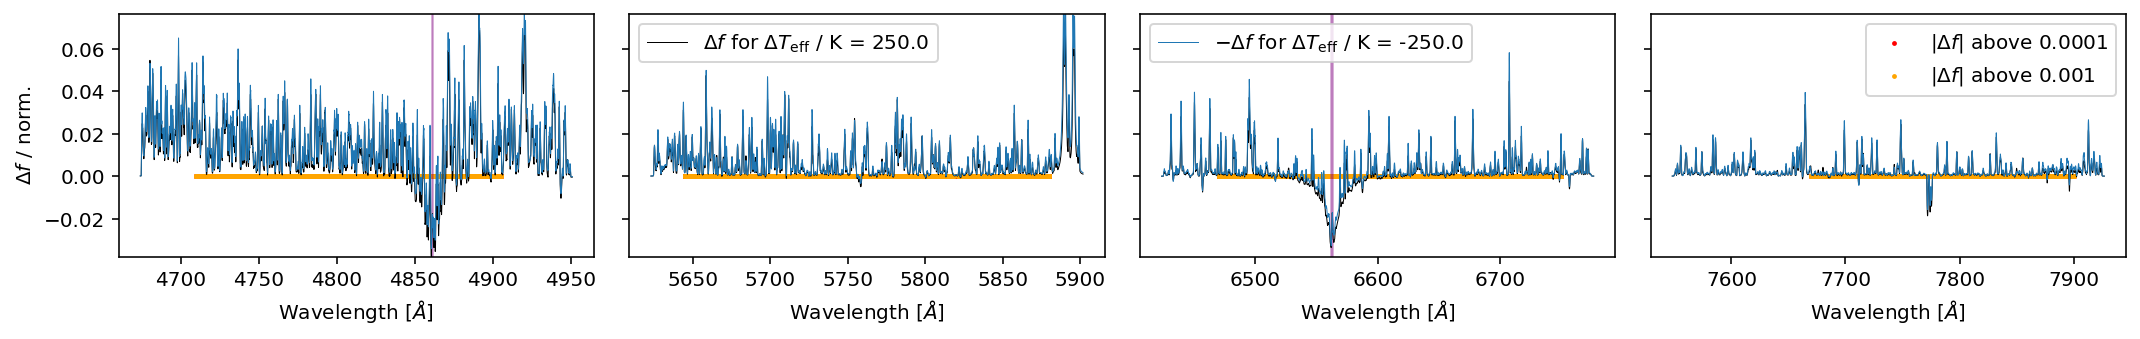

logg 0.5
0.0001:    94.4% 44286
0.001:    55.3% 25956


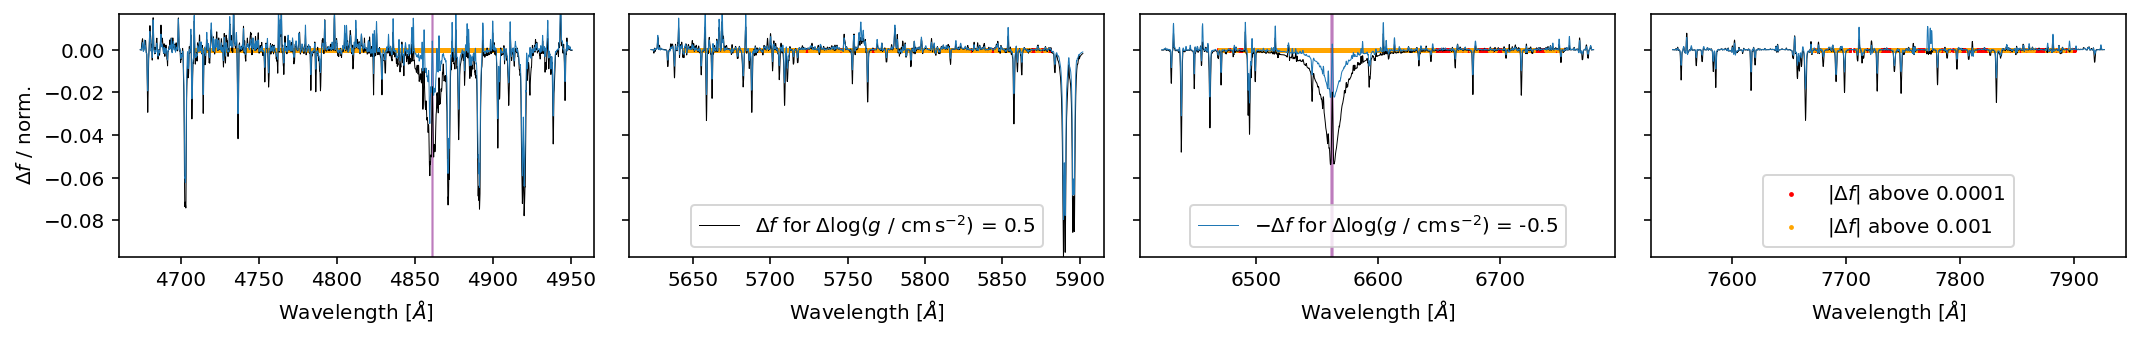

fe_h 0.25
0.0001:    100.0% 46918
0.001:    96.2% 45153


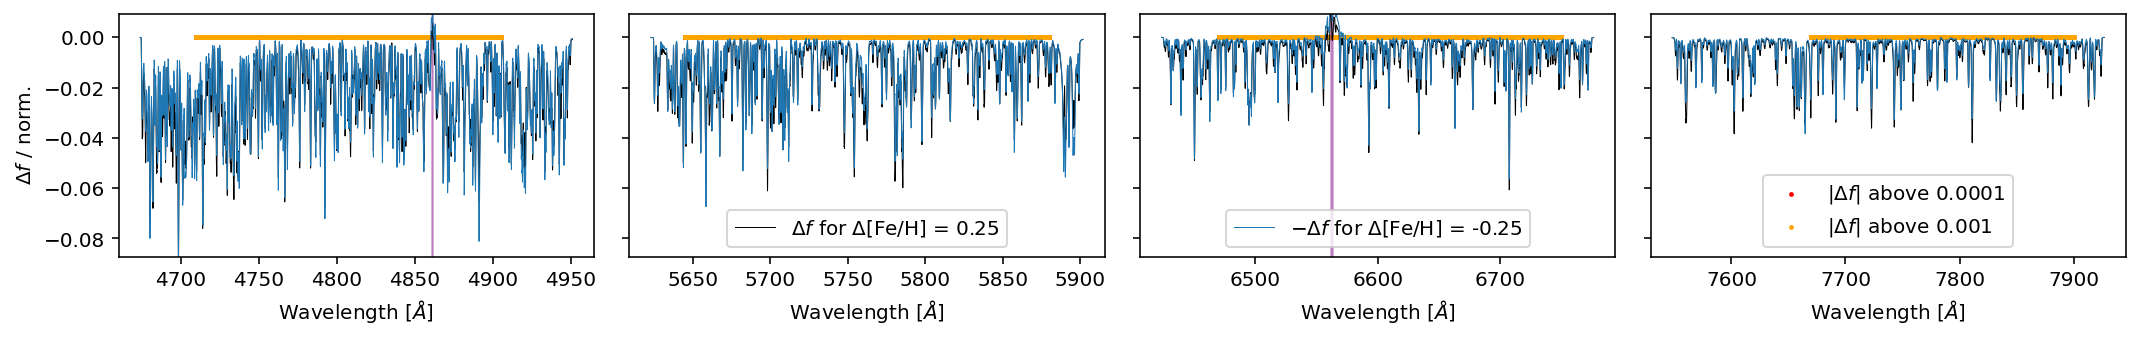

vmic 1.0
0.0001:    62.1% 29132
0.001:    39.9% 18723


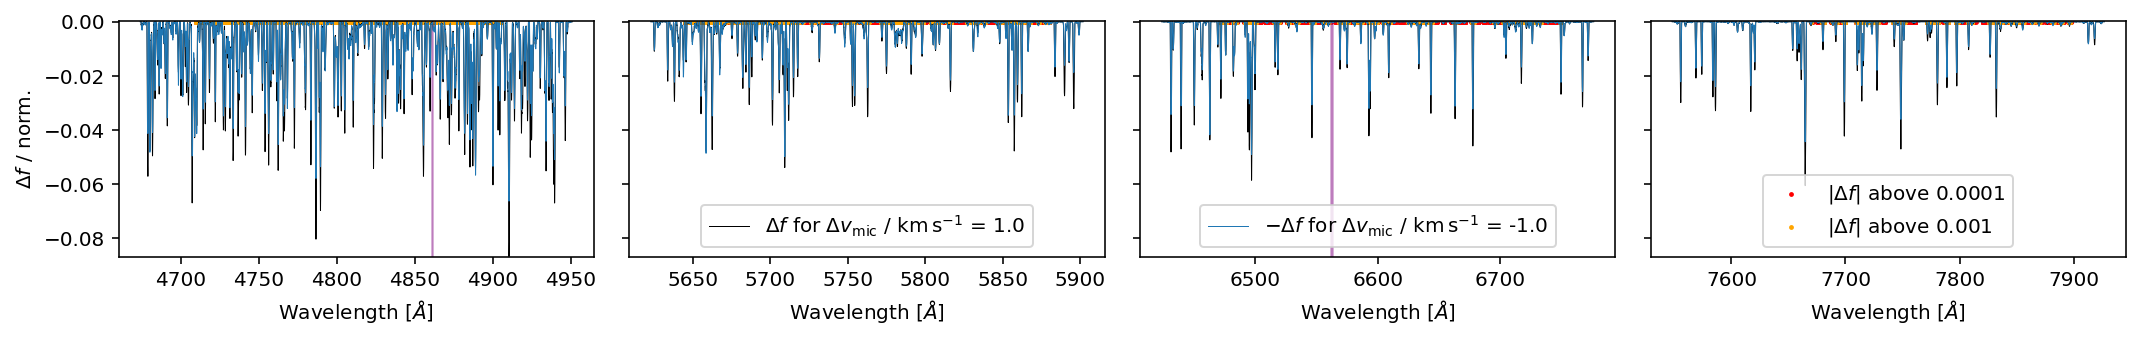

li_fe 1.25
0.0001:    0.8% 372
0.001:    0.3% 127


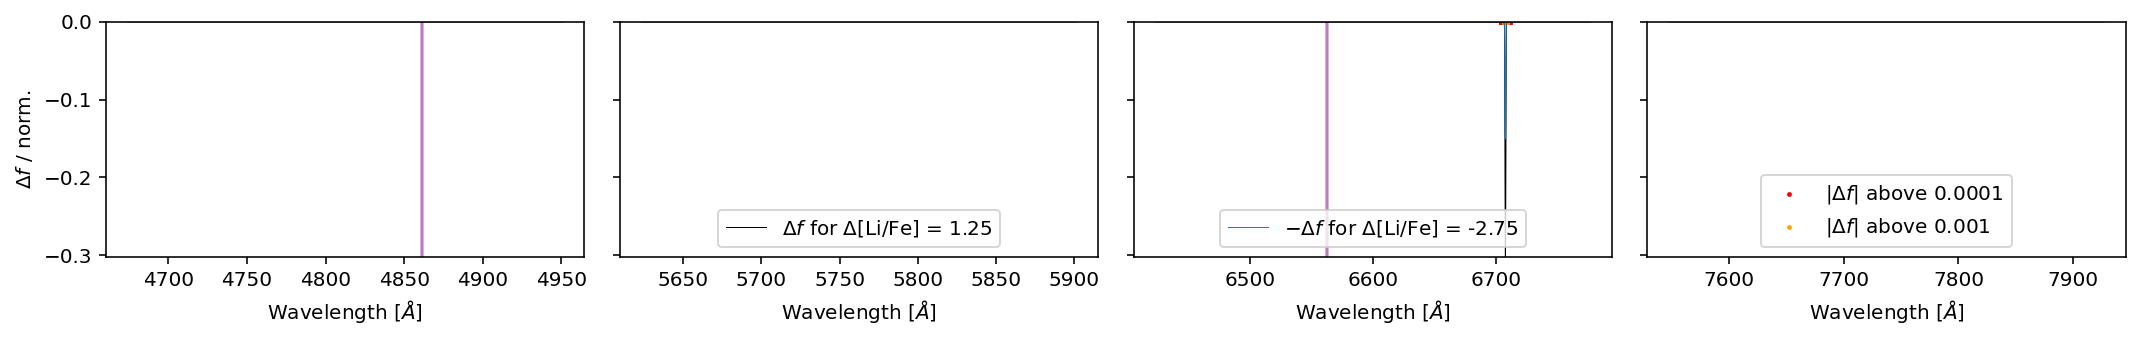

c_fe 1.5
0.0001:    99.9% 46867
0.001:    98.6% 46240


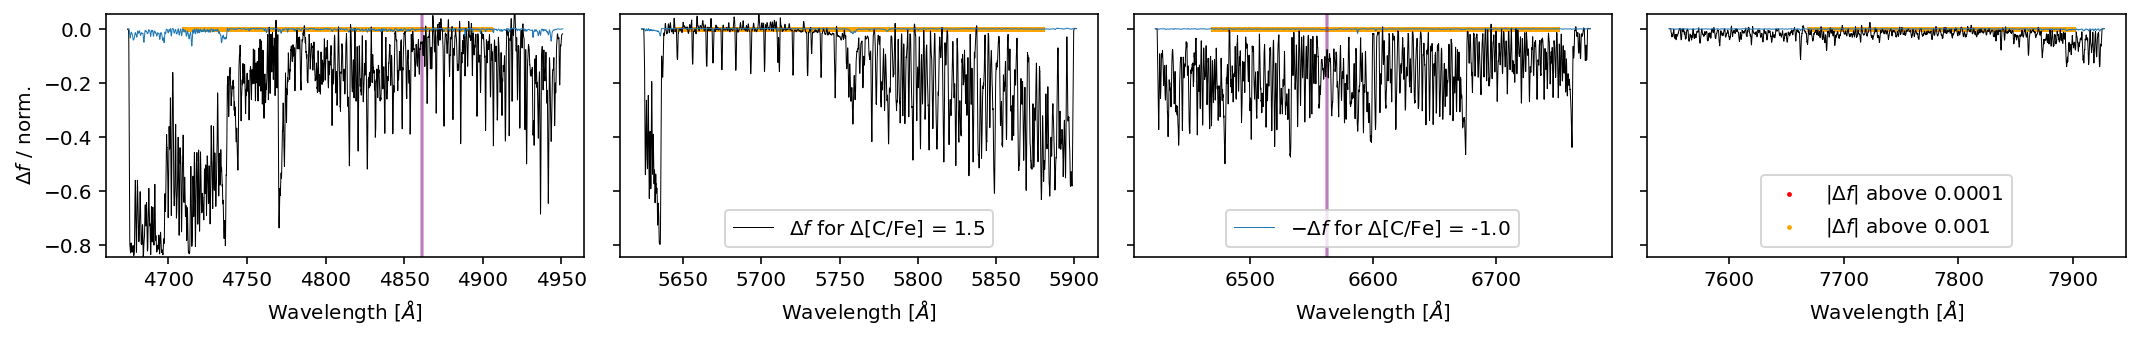

n_fe 1.5
0.0001:    99.7% 46759
0.001:    94.9% 44526


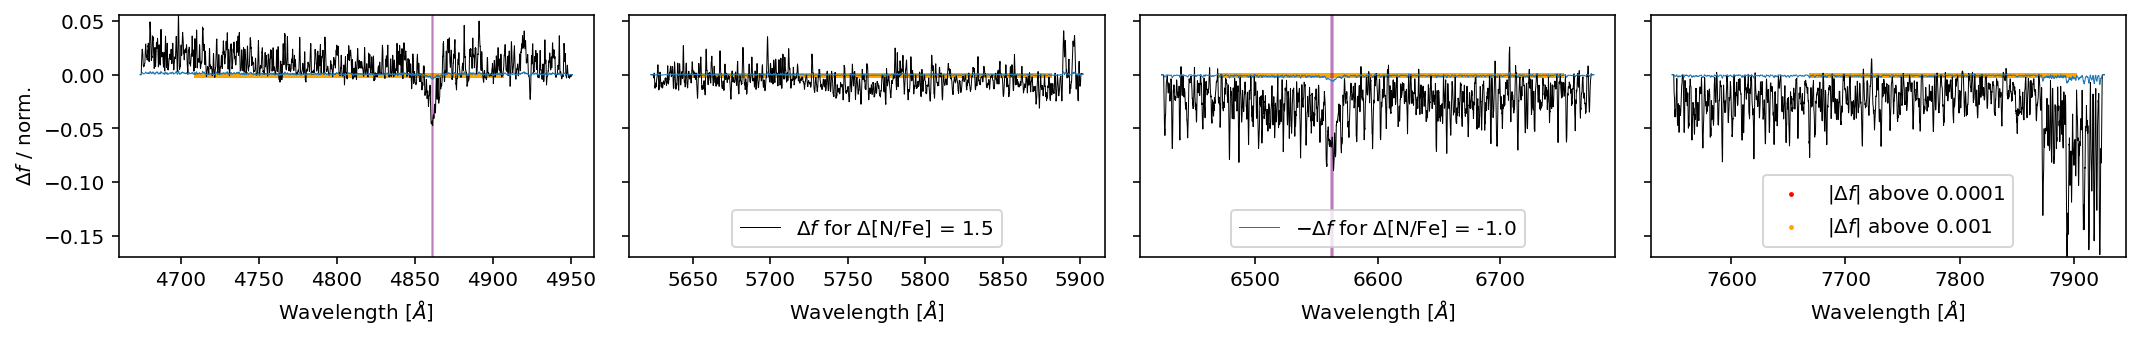

o_fe 1.5
0.0001:    97.7% 45840
0.001:    67.8% 31789


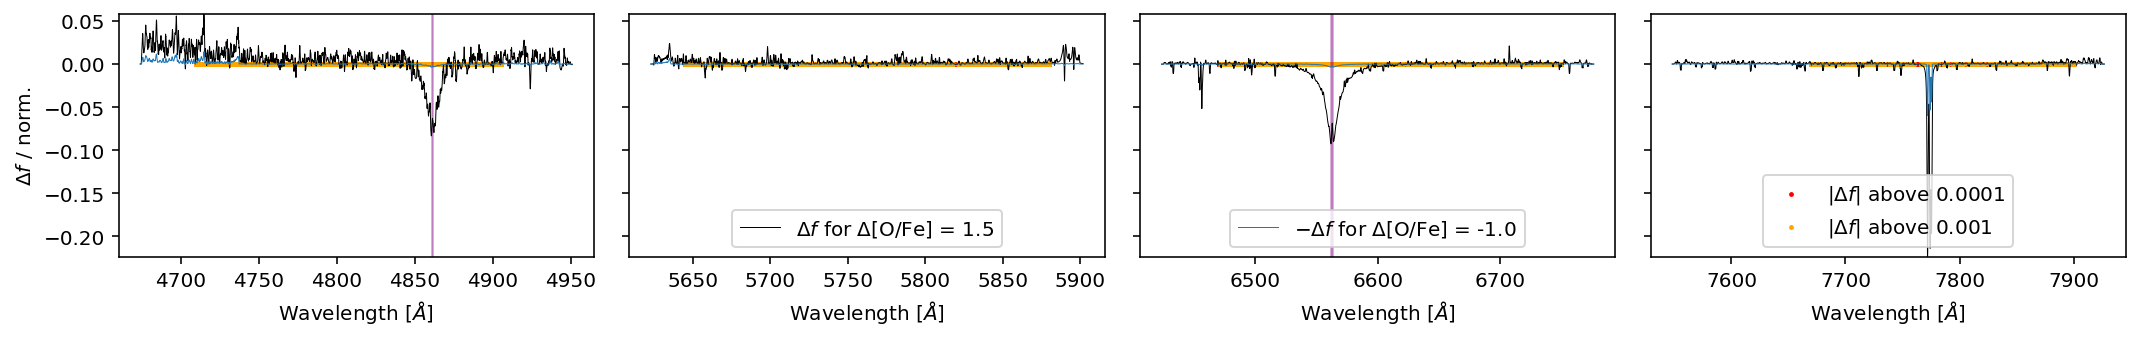

na_fe 1.0
0.0001:    77.3% 36252
0.001:    31.2% 14650


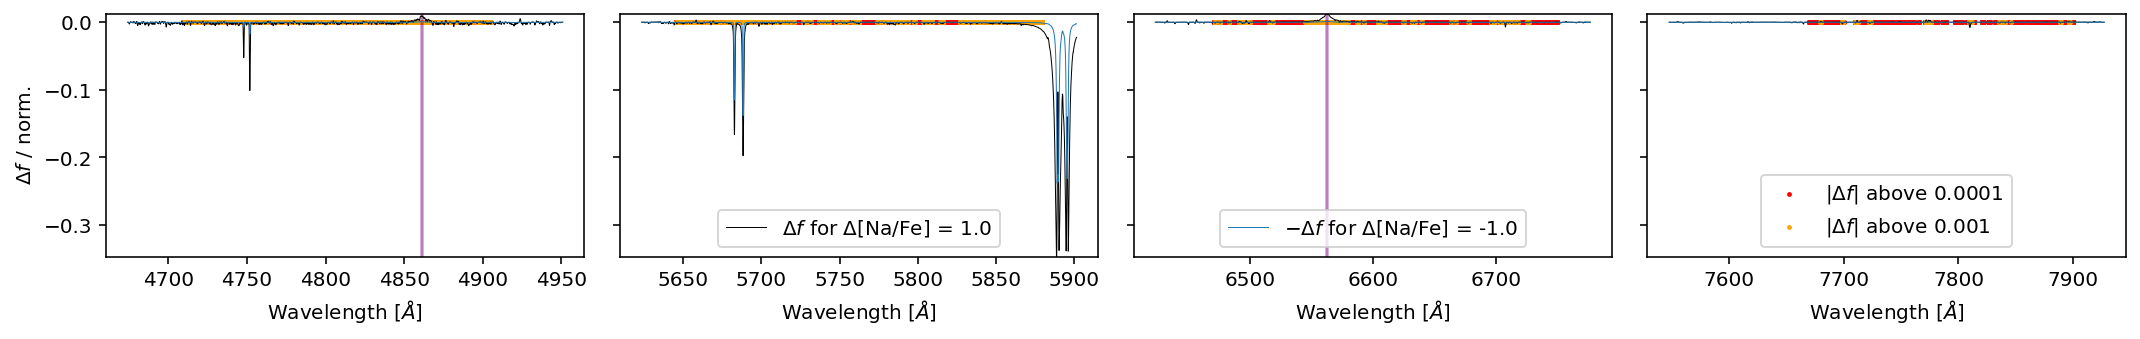

mg_fe 1.0
0.0001:    98.9% 46393
0.001:    81.7% 38333


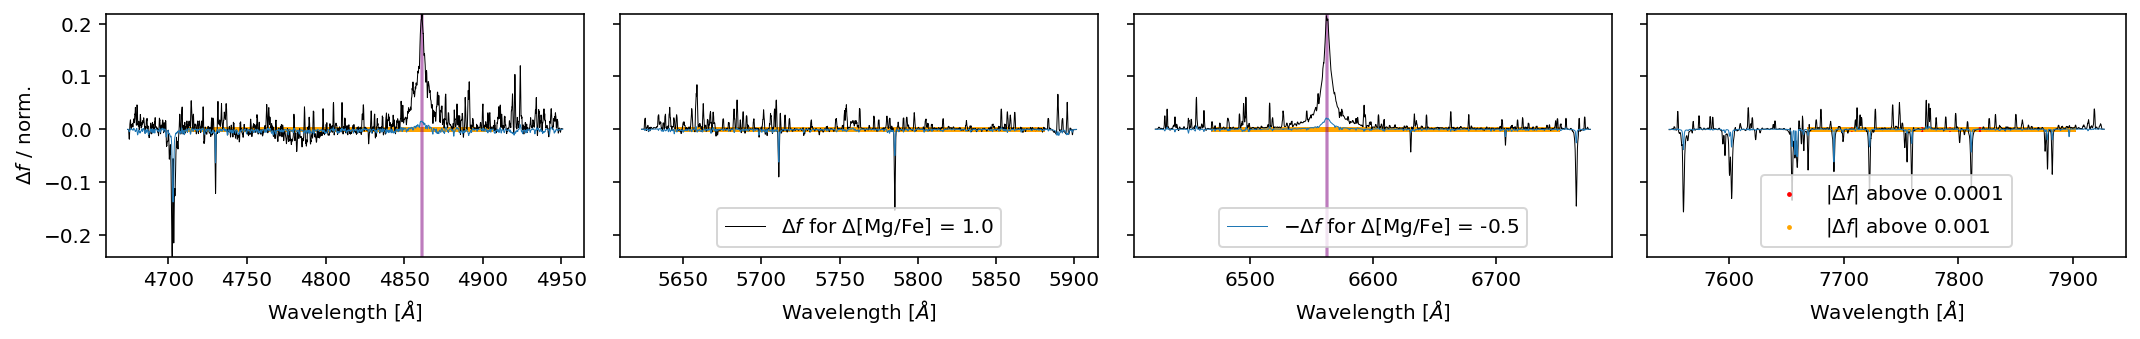

al_fe 1.0
0.0001:    79.7% 37374
0.001:    36.1% 16934


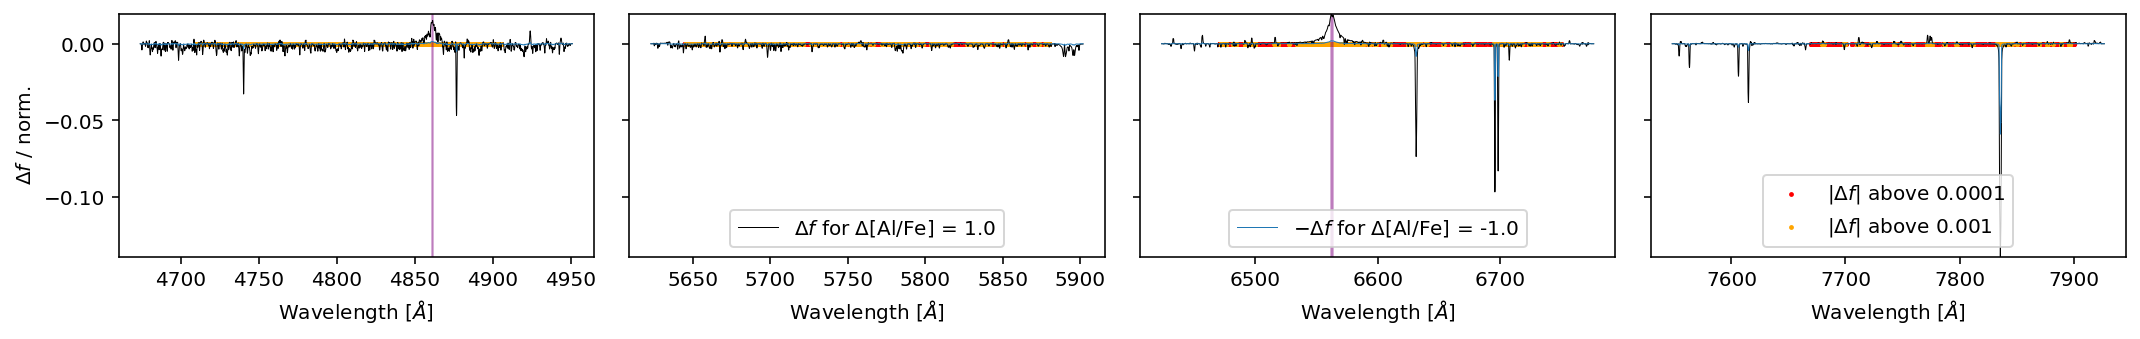

si_fe 1.0
0.0001:    97.9% 45948
0.001:    73.5% 34506


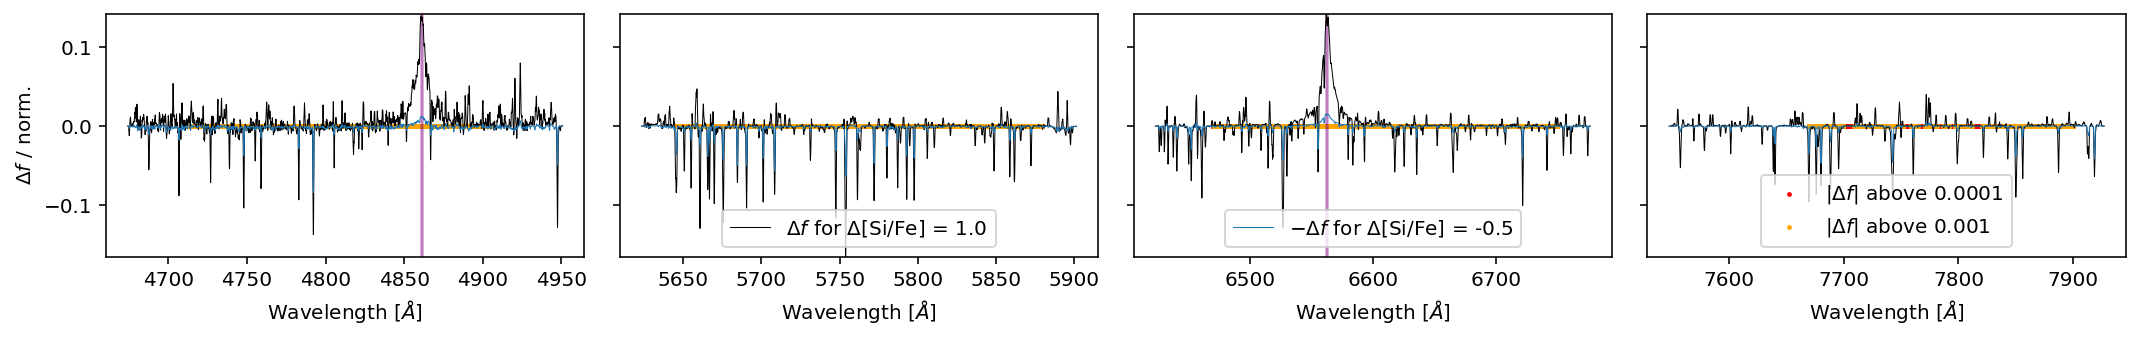

k_fe 1.0
0.0001:    29.4% 13795
0.001:    2.0% 917


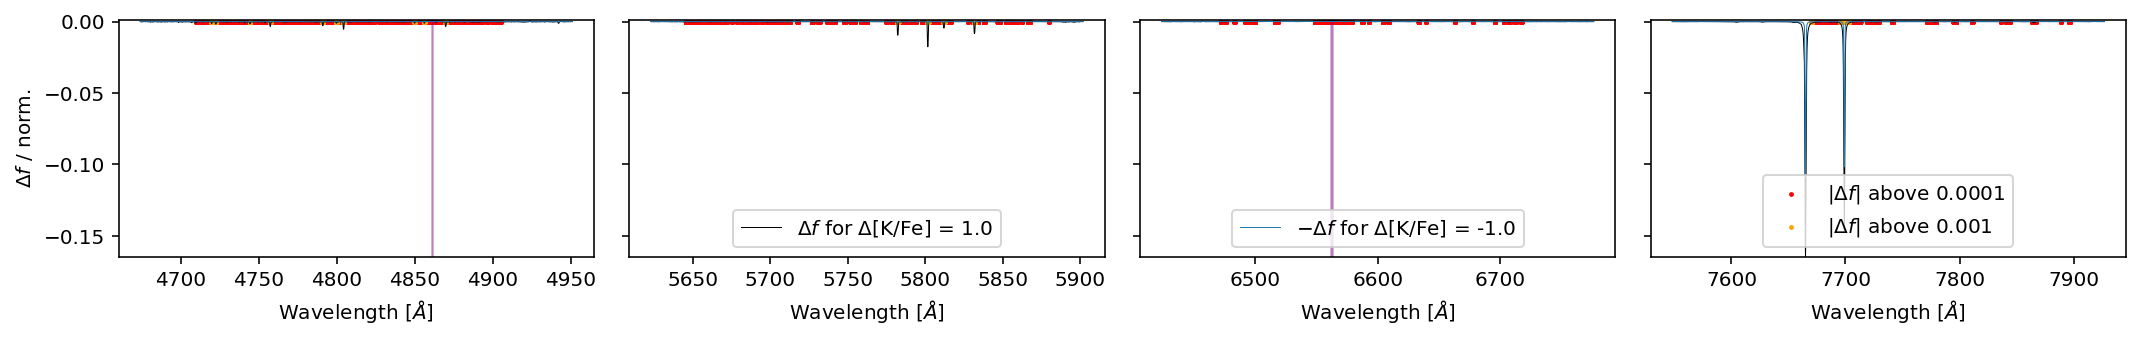

ca_fe 1.0
0.0001:    83.9% 39357
0.001:    44.4% 20819


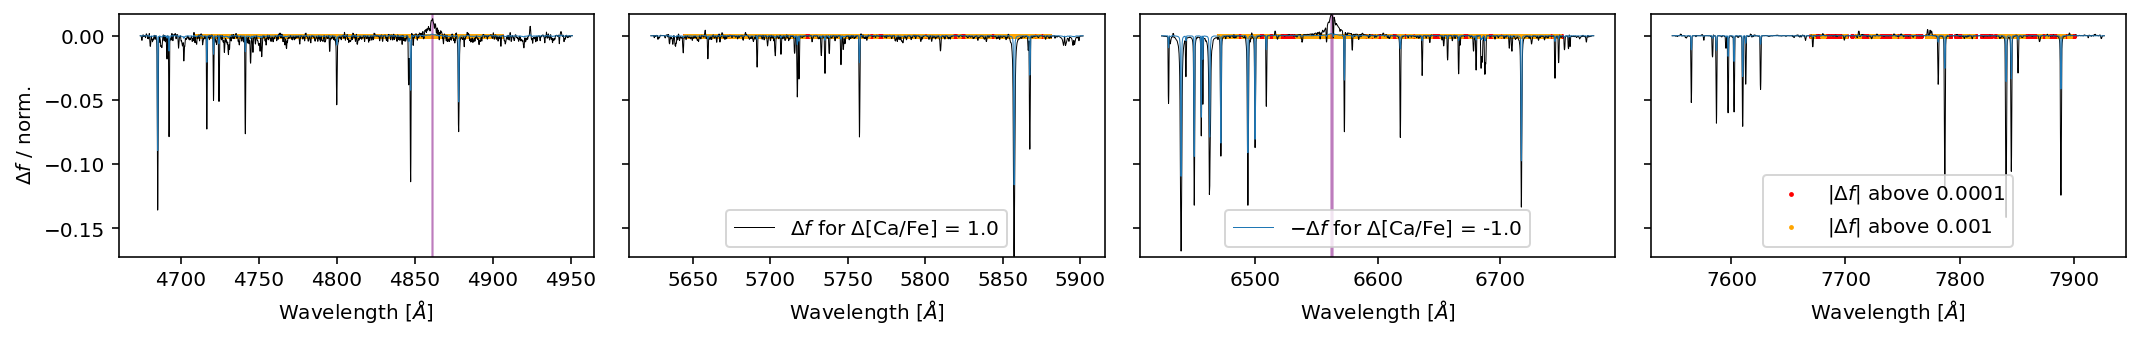

sc_fe 1.0
0.0001:    11.6% 5459
0.001:    5.4% 2547


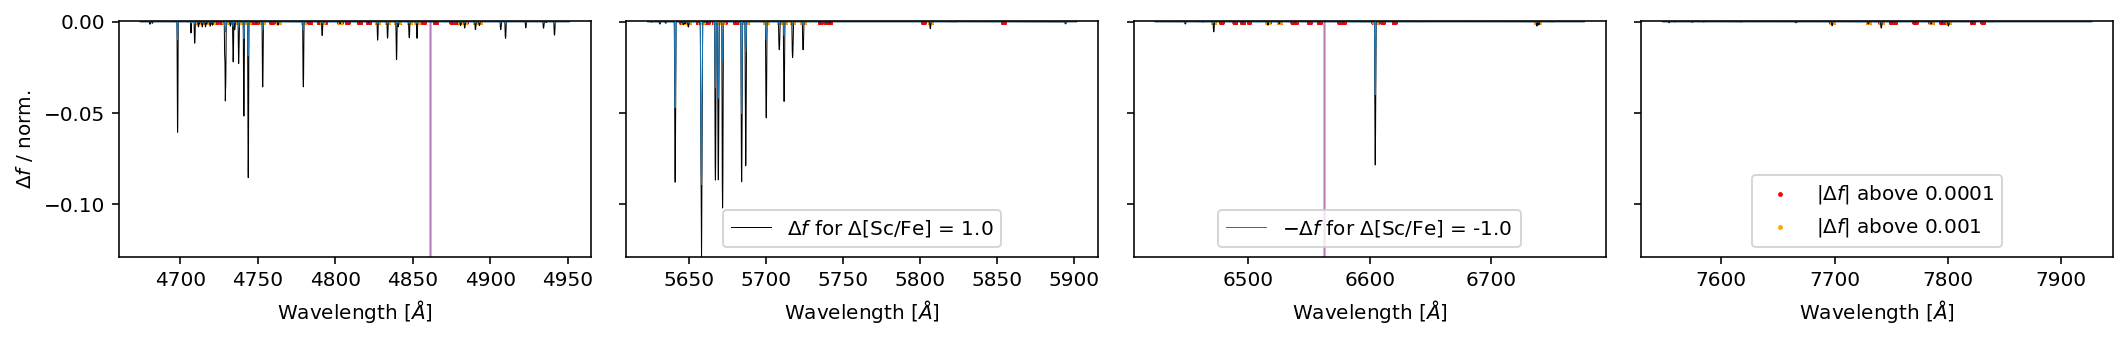

ti_fe 1.0
0.0001:    63.7% 29897
0.001:    33.4% 15659


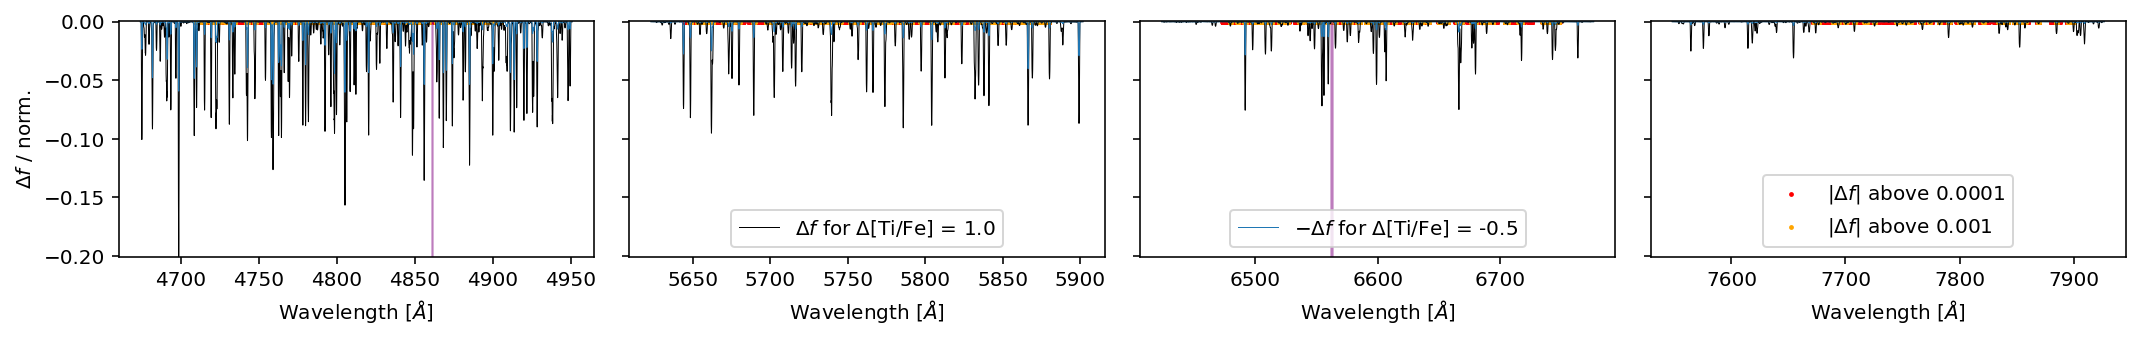

v_fe 1.0
0.0001:    37.4% 17549
0.001:    20.1% 9436


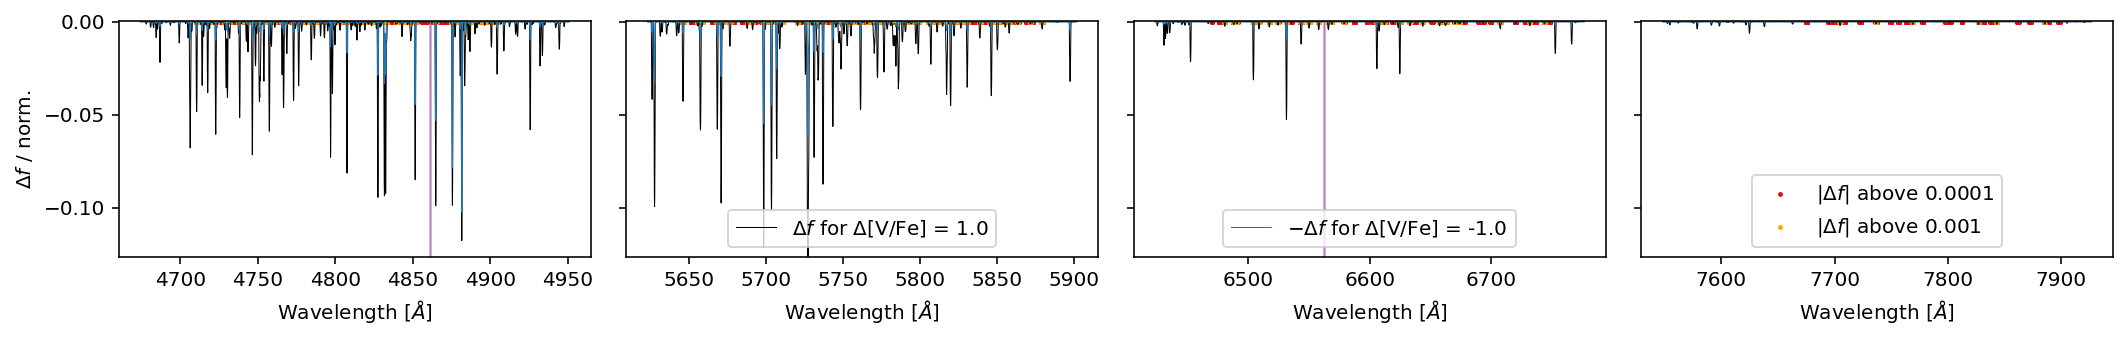

cr_fe 1.0
0.0001:    74.3% 34881
0.001:    39.9% 18720


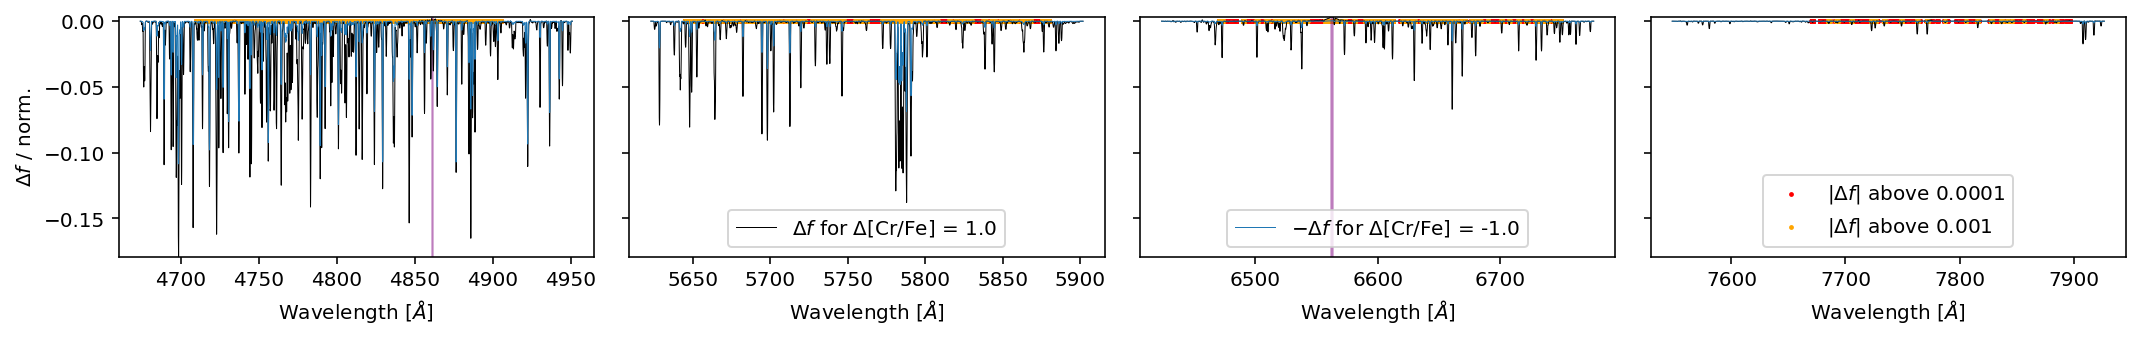

mn_fe 1.0
0.0001:    50.9% 23889
0.001:    15.5% 7295


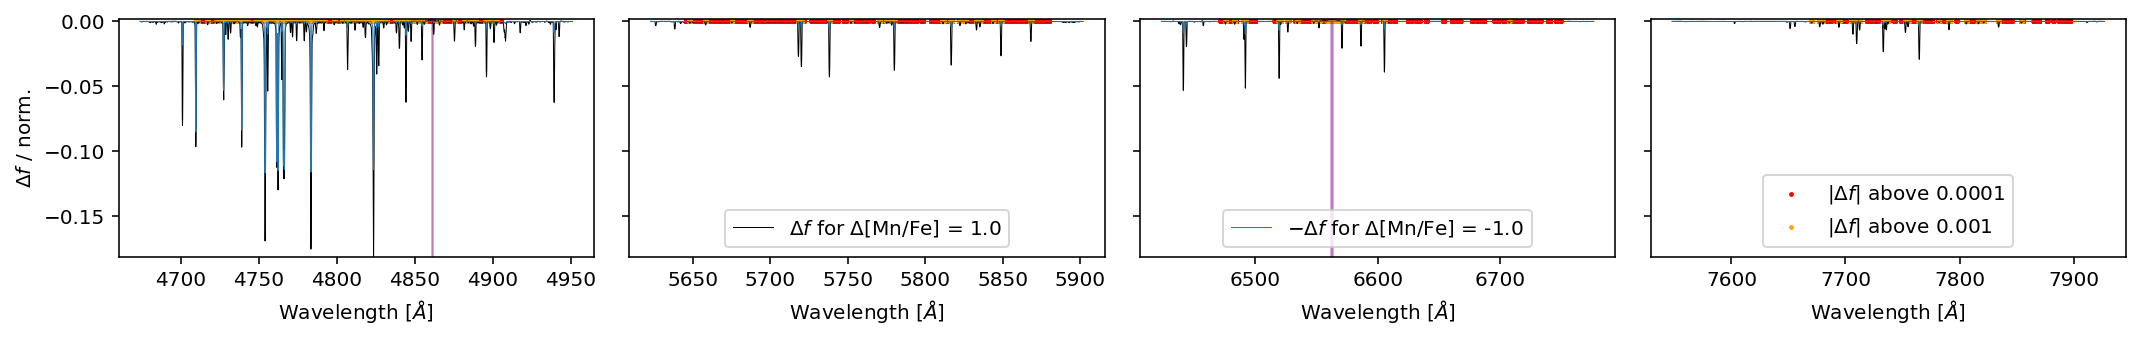

co_fe 1.0
0.0001:    37.8% 17742
0.001:    17.7% 8326


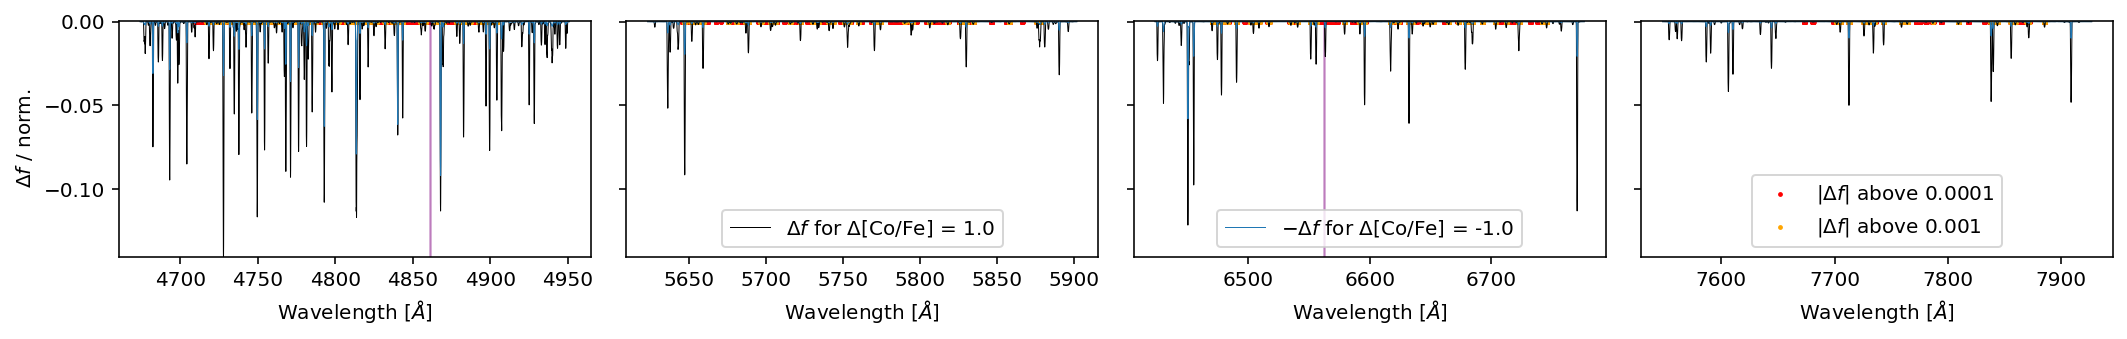

ni_fe 1.0
0.0001:    80.9% 37946
0.001:    43.0% 20195


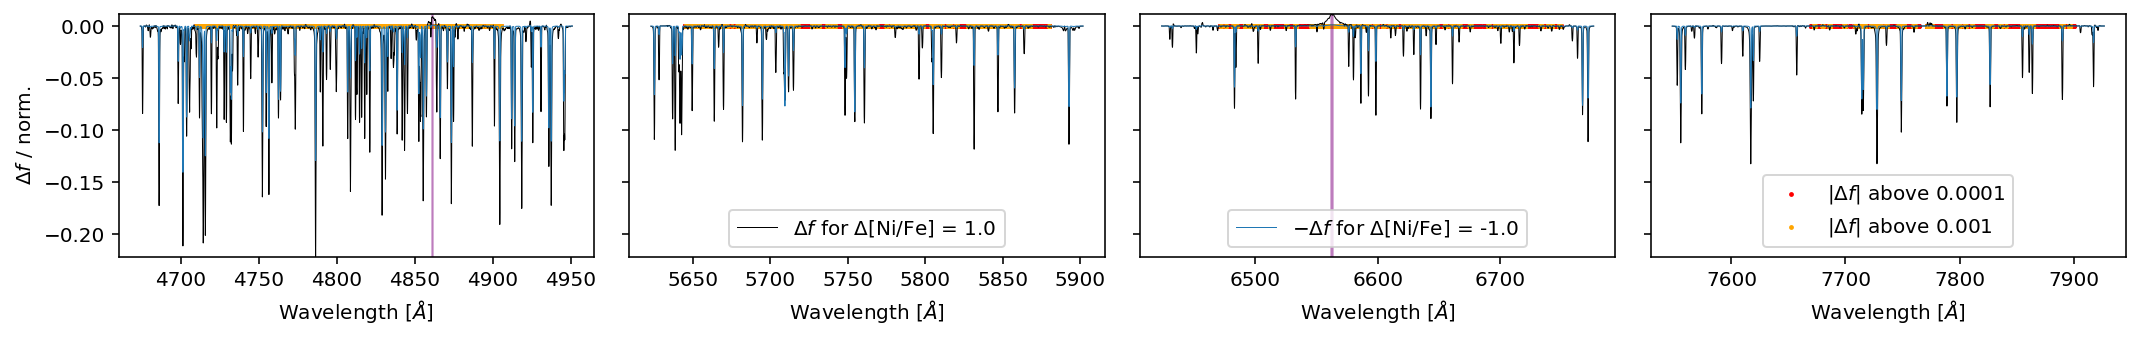

cu_fe 1.0
0.0001:    2.7% 1279
0.001:    0.8% 383


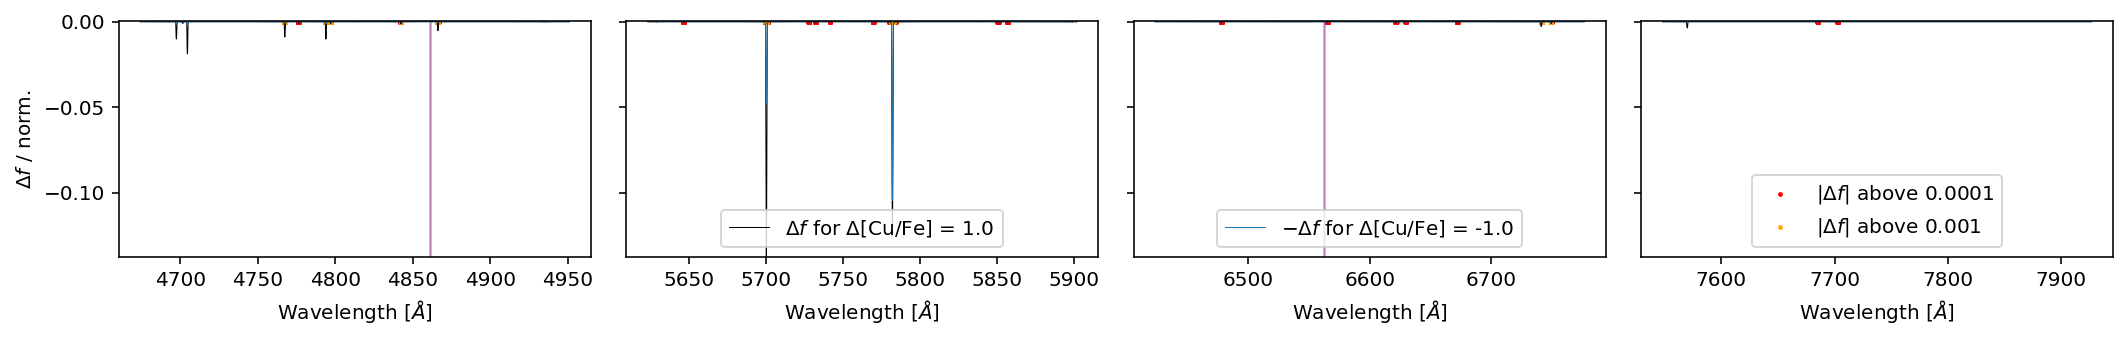

zn_fe 1.0
0.0001:    3.2% 1518
0.001:    0.9% 417


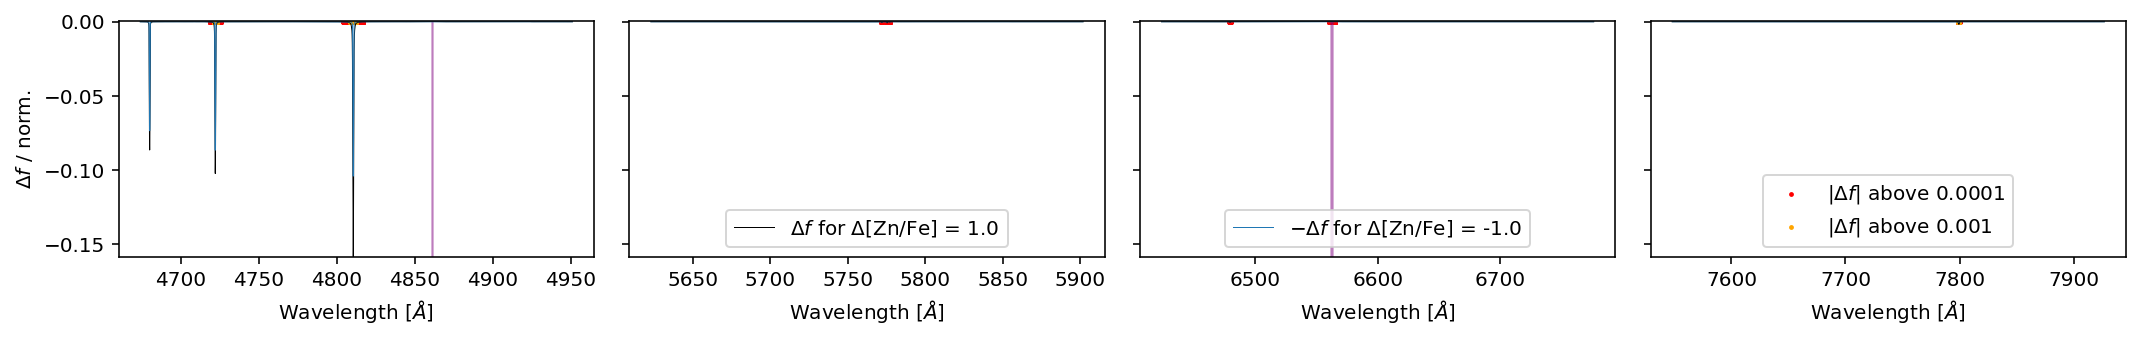

rb_fe 1.0
0.0001:    0.3% 141
0.001:    0.1% 54


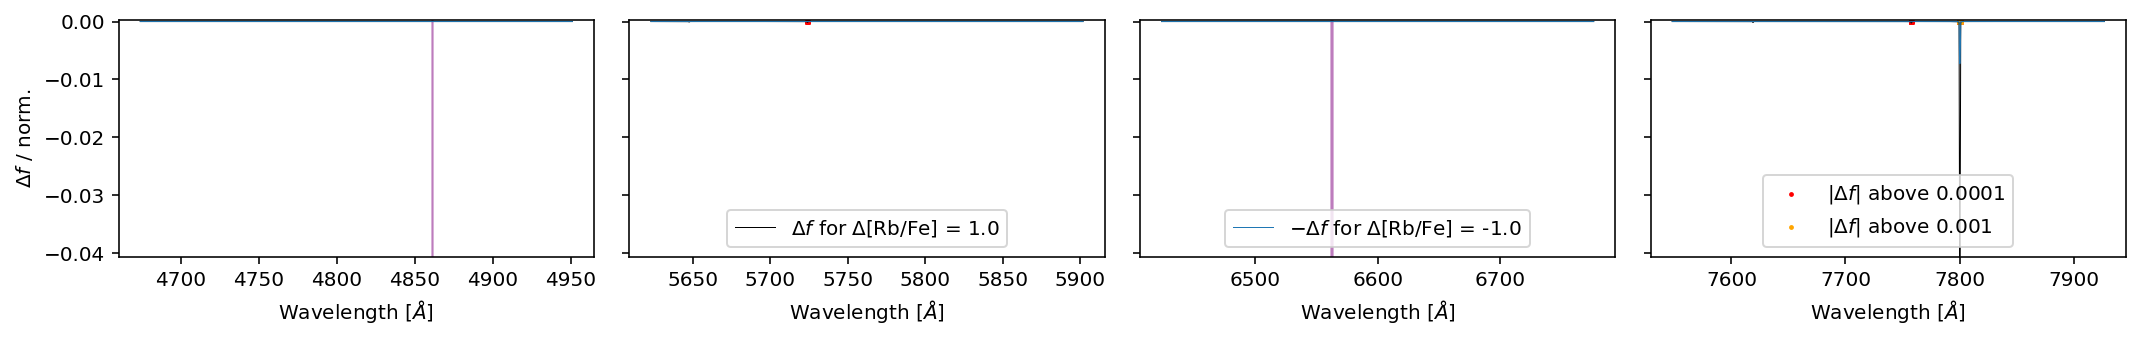

sr_fe 1.0
0.0001:    2.5% 1172
0.001:    1.9% 871


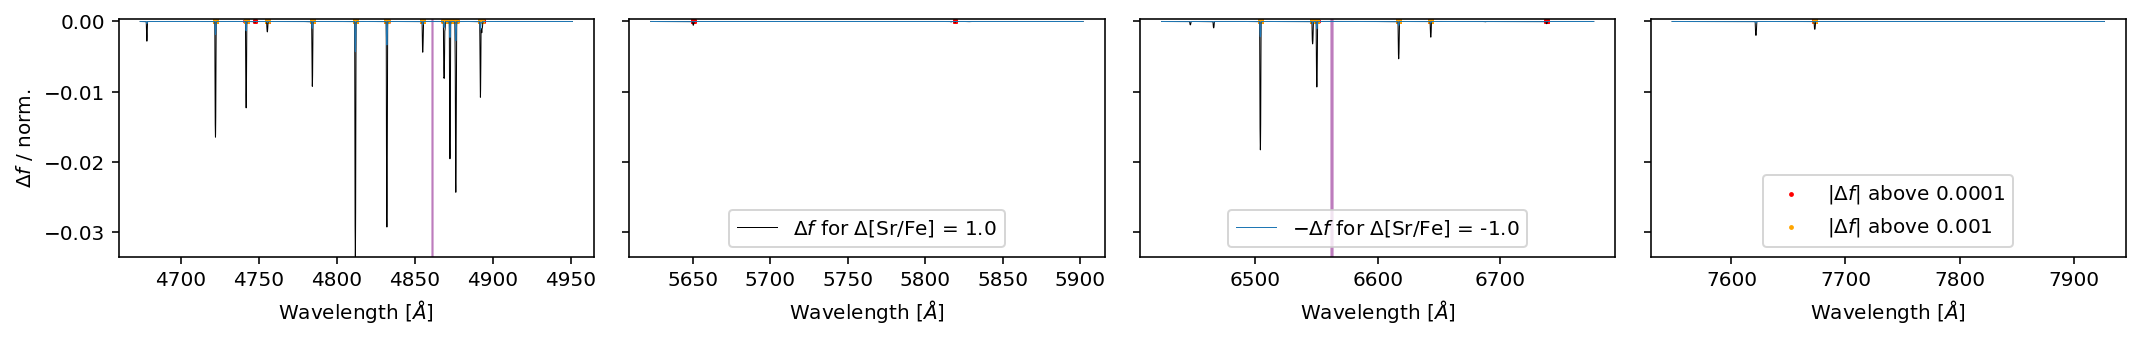

y_fe 1.5
0.0001:    15.4% 7239
0.001:    6.2% 2898


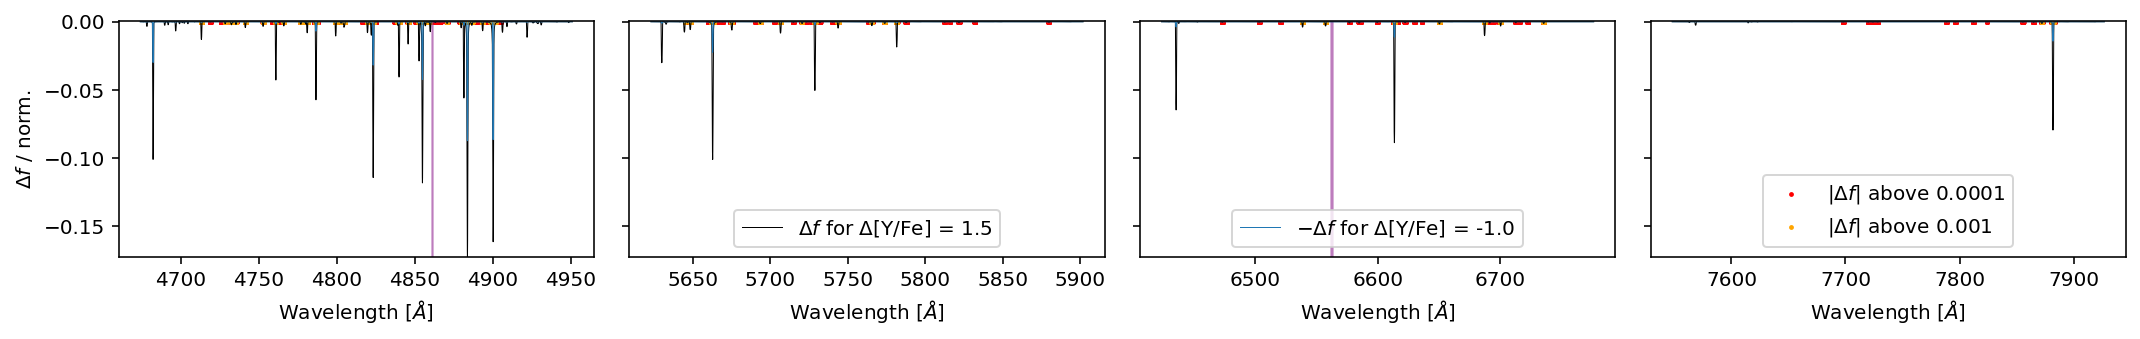

zr_fe 1.0
0.0001:    8.3% 3874
0.001:    3.5% 1641


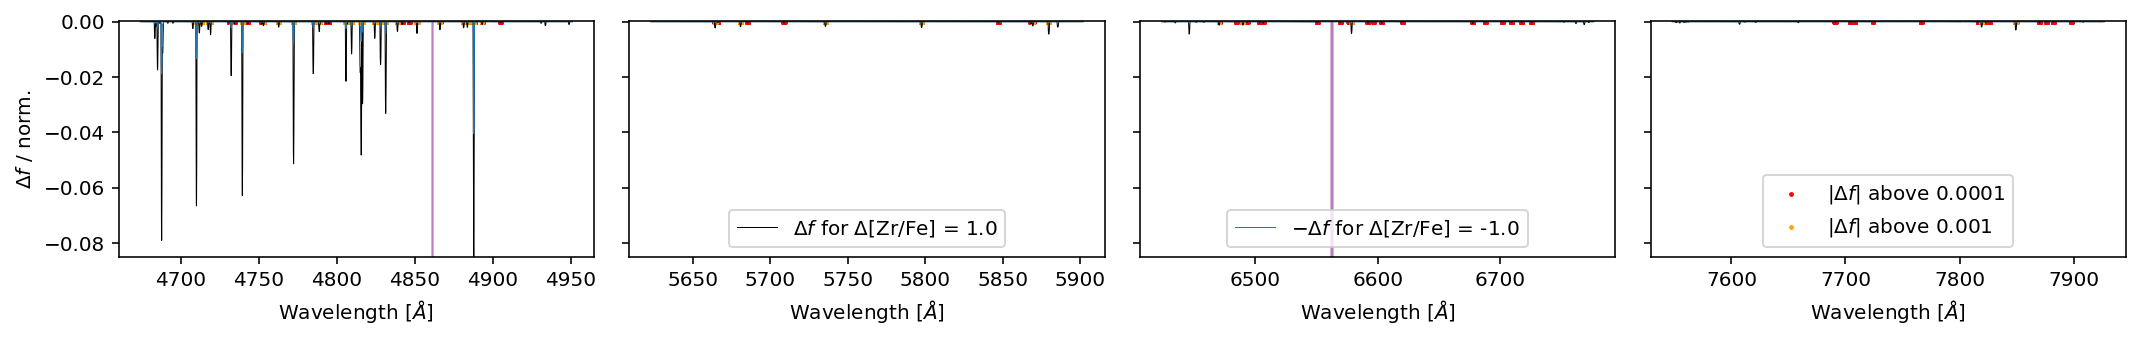

mo_fe 1.0
0.0001:    4.4% 2067
0.001:    1.1% 495


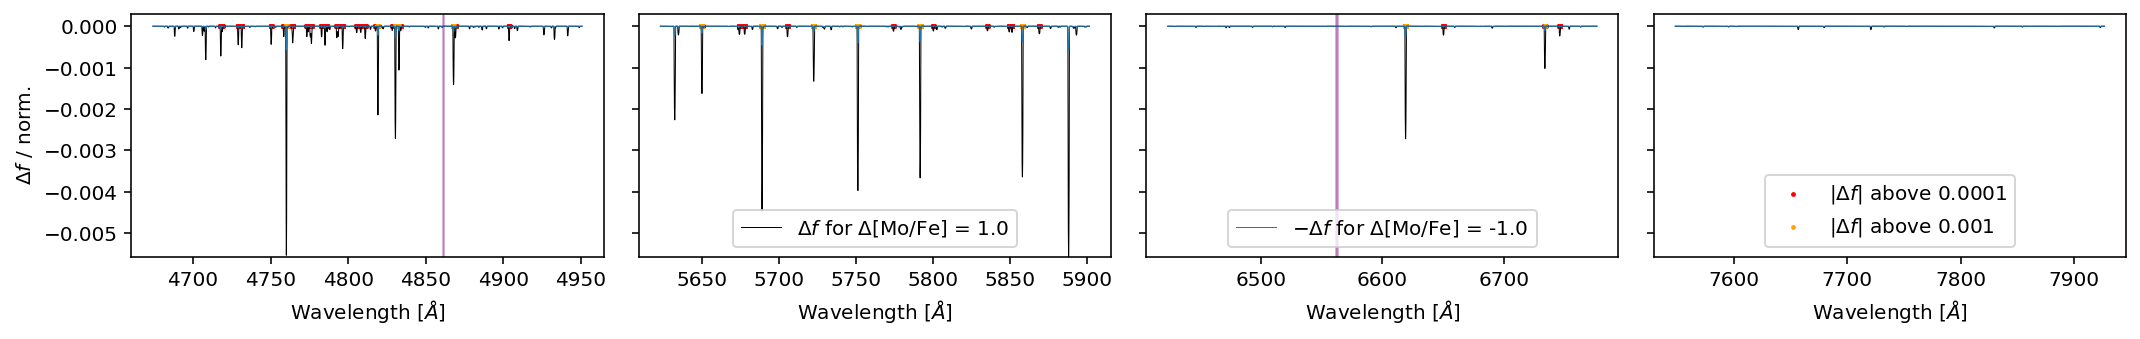

ru_fe 1.0
0.0001:    3.4% 1580
0.001:    0.8% 368


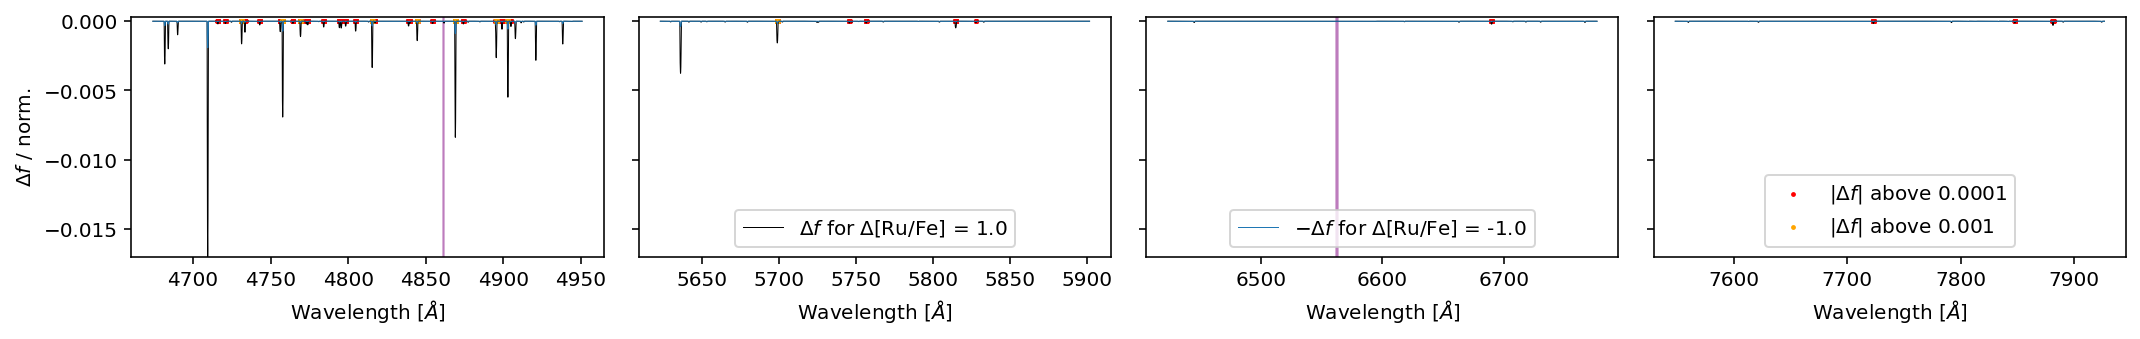

ba_fe 1.5
0.0001:    6.6% 3103
0.001:    2.7% 1282


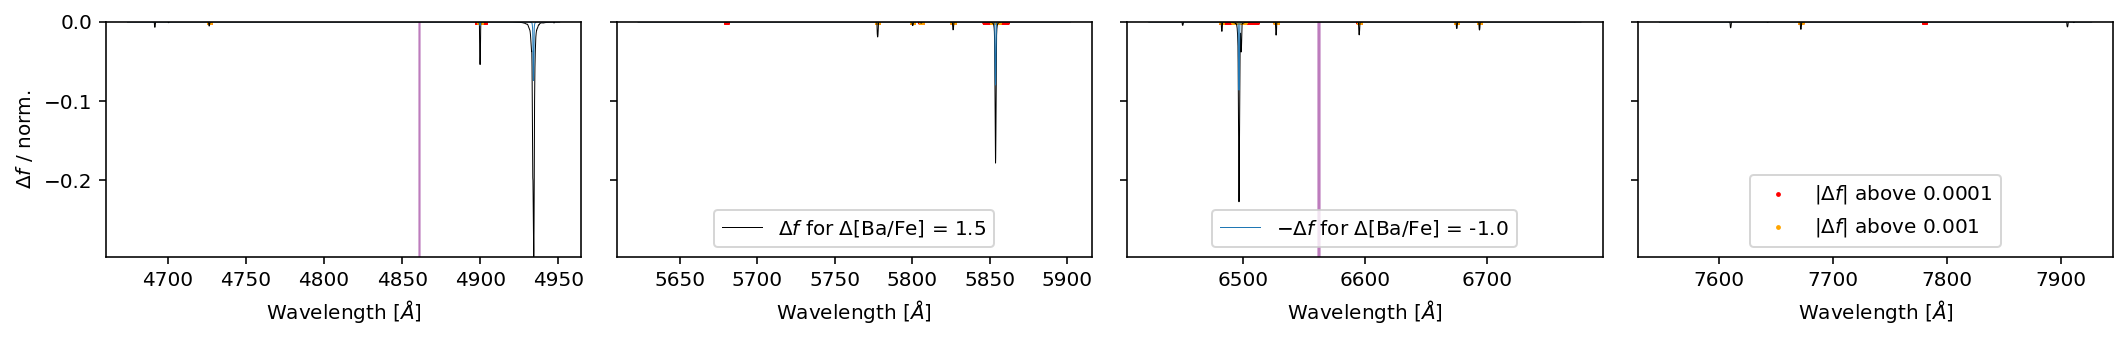

la_fe 1.5
0.0001:    6.4% 2998
0.001:    3.8% 1791


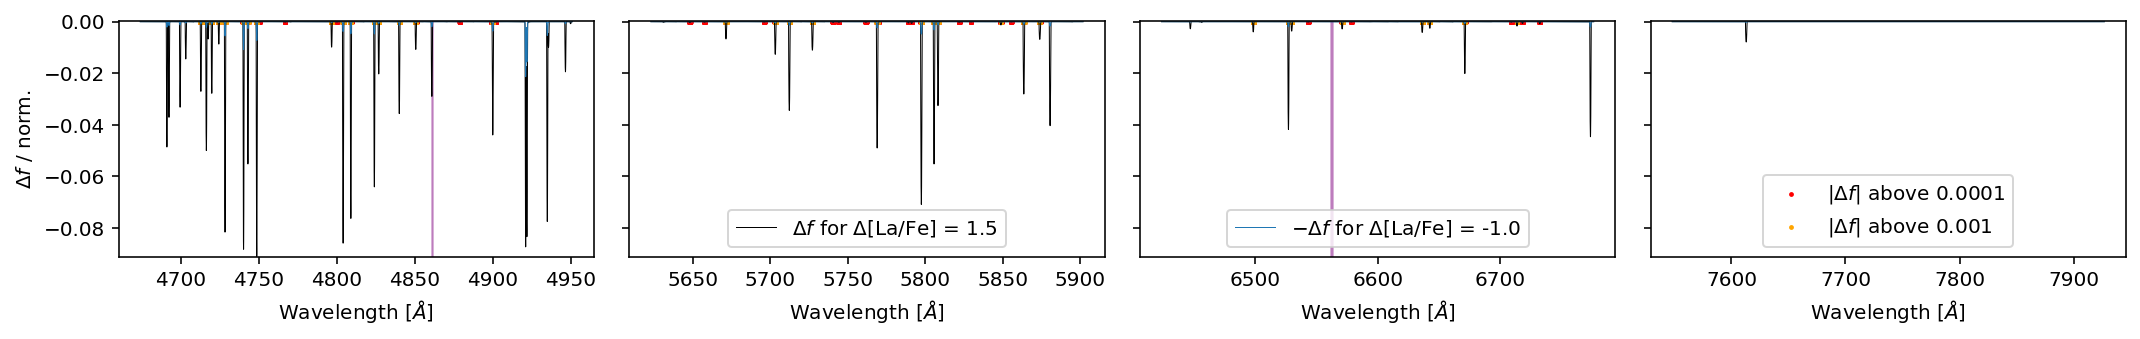

ce_fe 1.5
0.0001:    62.7% 29418
0.001:    38.8% 18196


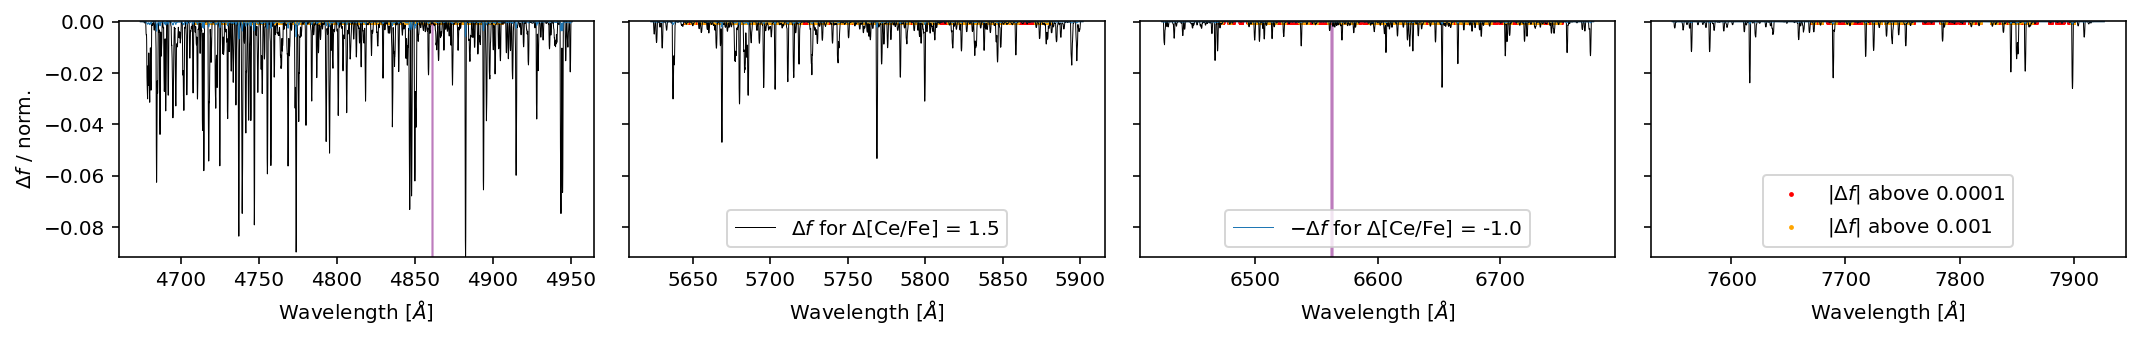

nd_fe 1.5
0.0001:    21.1% 9918
0.001:    14.4% 6776


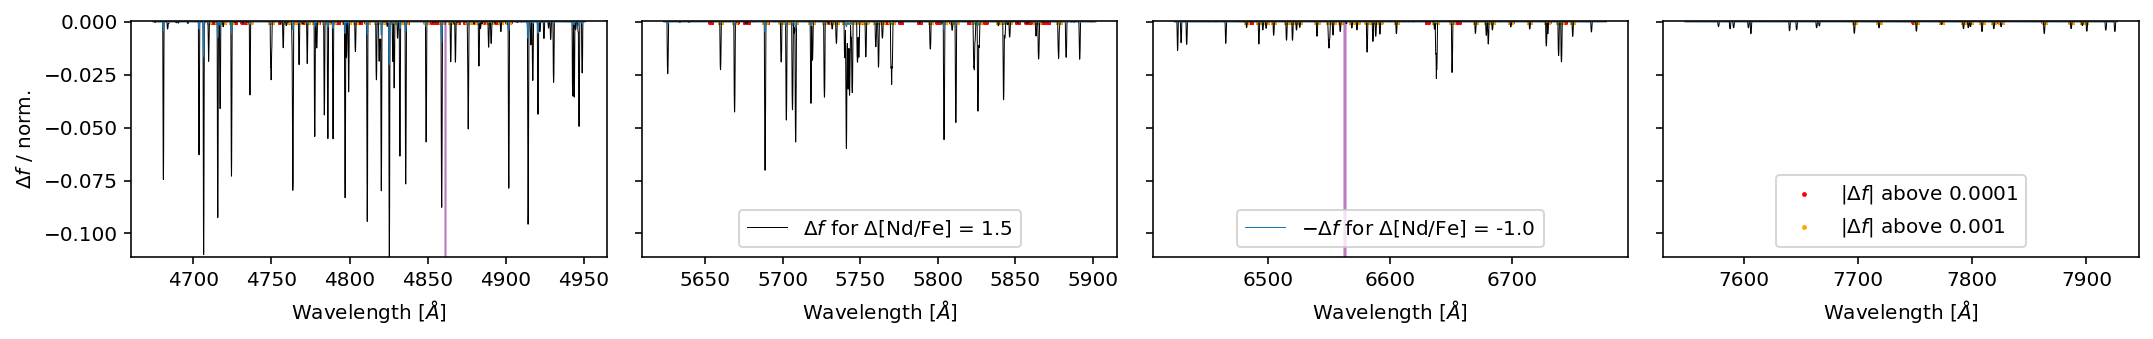

sm_fe 1.0
0.0001:    13.4% 6282
0.001:    6.3% 2942


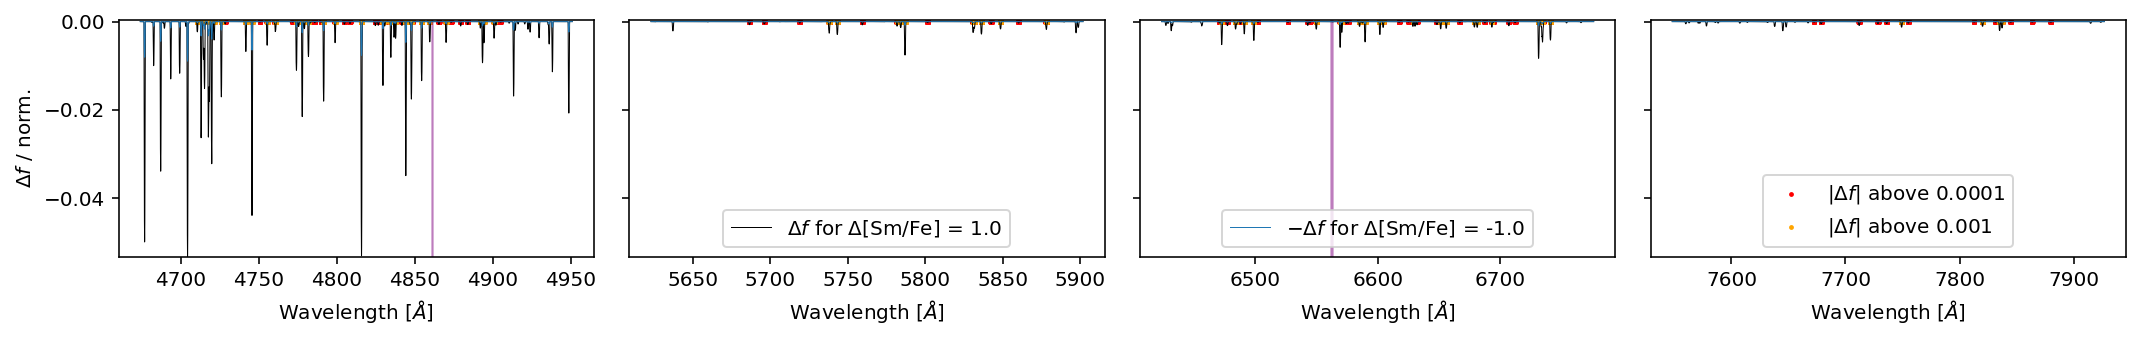

eu_fe 1.0
0.0001:    0.5% 252
0.001:    0.3% 136


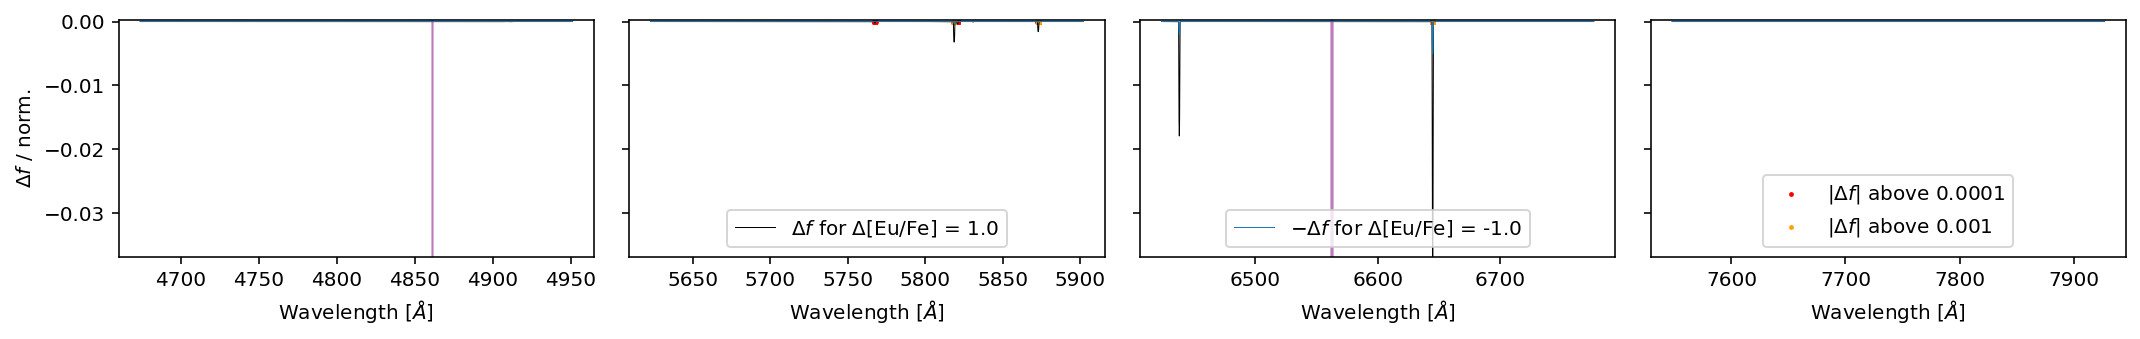

In [14]:
grid_masks = Table()

percentage_used = []

Path('gradient_spectra/'+teff_logg_feh_name).mkdir(parents=True, exist_ok=True)

for label_index, label in enumerate(labels):
    print(label, training_set_vsini0[label][2+label_index]-training_set_vsini0[label][0])
       
    threshold1 = 0.0001
    threshold2 = 0.001
    

    below_threshold1 = len(np.where(np.max([np.abs(gradient_spectra_up[label][usual_galah_range_without_balmer_cores]),np.abs(gradient_spectra_down[label][usual_galah_range_without_balmer_cores])],axis=0) >= threshold1)[0])
    below_threshold2 = len(np.where(np.max([np.abs(gradient_spectra_up[label][usual_galah_range_without_balmer_cores]),np.abs(gradient_spectra_down[label][usual_galah_range_without_balmer_cores])],axis=0) >= threshold2)[0])
    
    print(str(threshold1)+':   ',"{:.1f}".format(100*below_threshold1/total_usual)+'%',below_threshold1)
    print(str(threshold2)+':   ',"{:.1f}".format(100*below_threshold2/total_usual)+'%',below_threshold2)
    
    percentage_used.append([fancy_labels[label_index], r'$\pm$'+str(training_set_vsini0[label][2+label_index]-training_set_vsini0[label][0]), "{:.1f}".format(100*below_threshold1/total_usual),"{:.1f}".format(100*below_threshold2/total_usual)])
    
    above_threshold1 = (np.max([np.abs(gradient_spectra_up[label]),np.abs(gradient_spectra_down[label])],axis=0) >= threshold1) & usual_galah_range_without_balmer_cores
    above_threshold2 = (np.max([np.abs(gradient_spectra_up[label]),np.abs(gradient_spectra_down[label])],axis=0) >= threshold2) & usual_galah_range_without_balmer_cores

    grid_masks[label] = above_threshold2
    
    f, gs = plt.subplots(1,4,figsize=(15,2.5),sharey=True)
    for ccd in [1,2,3,4]:
        plot_label = '_nolegend_'
        if ccd == 2:
            plot_label = r'$\Delta f$ for $\Delta$'+fancy_labels[label_index]+' = '+str(training_set_vsini0[label][2+label_index]-training_set_vsini0[label][0])
        in_ccd = (gradient_spectra_up['wave'] > (3+ccd)*1000) & (gradient_spectra_up['wave'] < (4+ccd)*1000)
        ax=gs[ccd-1]
        if ccd == 1:
            ax.axvspan(4860.90, 4861.77, color='purple',alpha=0.3)
        if ccd == 3:
            ax.axvspan(6562.00, 6563.60, color='purple',alpha=0.3)
        ax.plot(
            gradient_spectra_up['wave'][in_ccd],
            gradient_spectra_up[label][in_ccd],
            c='k',lw=0.5,label = plot_label
        )
        plot_label = '_nolegend_'
        if ccd == 3:
            plot_label = r'$-\Delta f$ for $\Delta$'+fancy_labels[label_index]+' = '+str(training_set_vsini0[label][37+label_index]-training_set_vsini0[label][0])
        ax.plot(
            gradient_spectra_down['wave'][in_ccd],
            -gradient_spectra_down[label][in_ccd],
            c='C0',lw=0.5,label = plot_label
        )
        ax.set_xlabel(r'Wavelength [$\AA$]')
        if ccd==1:
            ax.set_ylabel(r'$\Delta f~/~\mathrm{norm.}$')
        plot_label = '_nolegend_'
        if ccd == 4:
            plot_label = r'$\vert\Delta f\vert$ above '+str(0.0001)
        ax.scatter(
            gradient_spectra_up['wave'][(above_threshold1 & in_ccd)],
            np.zeros(len(np.where(above_threshold1 & in_ccd==True)[0])),
            c='red',s=2,label=plot_label
        )
        plot_label = '_nolegend_'
        if ccd == 4:
            plot_label = r'$\vert\Delta f\vert$ above '+str(0.001)
        ax.scatter(
            gradient_spectra_up['wave'][(above_threshold2 & in_ccd)],
            np.zeros(len(np.where(above_threshold2 & in_ccd==True)[0])),
            c='orange',s=2,label=plot_label
        )
        ax.set_ylim(
            np.min([np.min(gradient_spectra_up[label]),-3*threshold1]),
            np.max([np.max(gradient_spectra_up[label]),3*threshold1])
        )
        if ccd in [2,3,4]:
            if label not in ['teff']:
                ax.legend(loc='lower center')
            else:
                ax.legend()
    plt.tight_layout()
    plt.savefig('gradient_spectra/'+teff_logg_feh_name+'/gradient_spectrum_'+teff_logg_feh_name+'_'+label+'.png',dpi=200,bbox_inches='tight')
    if grid_index in [1931]:
        if sys.argv[1] == '-f':
            plt.show()
        try:
            plt.savefig('../galah_dr4_paper/figures/gradient_spectrum_'+teff_logg_feh_name+'_'+label+'.png',dpi=200,bbox_inches='tight')
        except:
            pass
    plt.close()


In [15]:
if grid_index in [1931]:
    table_text = [
    [r'\begin{table}[!ht]'],
    [r'    \centering'],
    [r'    \caption{Example of mask estimation for \textit{The Cannon}/\textit{The Payne} model creation. Listed are percentages of the spectrum that respond to an in-/decrease of each label above 0.001 and 0.0001 of the normalised flux.}'],
    [r'    \label{tab:cannon_mask_percentage}'],
    [r'    \begin{tabular}{cccc}'],
    [r'    \hline \hline'],
    [r'    Label &  Label change & $\vert \Delta f \vert > 0.001~/~\%$ & $\vert \Delta f \vert > 0.0001~/~\%$ \\'],
    [r'    \hline']
    ]
    for each in percentage_used:
        table_text.append([r'    '+each[0]+' & '+each[1]+' & '+each[3]+' & '+each[2]+r' \\'])
    table_text.append([r'    \hline'])
    table_text.append([r'    \end{tabular}'])
    table_text.append([r'\end{table}'])

    try:
        np.savetxt('../galah_dr4_paper/tables/mask_percentage_1931.tex',np.array(table_text),fmt='%s')
    except:
        pass

In [16]:
Path('training_input/'+teff_logg_feh_name).mkdir(parents=True, exist_ok=True)

gradient_spectra_up.write('gradient_spectra/'+teff_logg_feh_name+'/'+teff_logg_feh_name+'_gradient_spectra_up.fits',overwrite=True)
gradient_spectra_down.write('gradient_spectra/'+teff_logg_feh_name+'/'+teff_logg_feh_name+'_gradient_spectra_down.fits',overwrite=True)
grid_masks.write('training_input/'+teff_logg_feh_name+'/'+teff_logg_feh_name+'_masks.fits',overwrite=True)

# Trainingset flux and ivar at different vsini values

In [17]:
# Prepare the full trainingset (including vsini sampled from vsini_values)

full_trainingset = Table()
for label in training_set_vsini0.keys()[:6]:
    full_trainingset[label] = np.concatenate((np.array([training_set_vsini0[label] for vsini in vsini_values])))
full_trainingset['vsini'] = np.concatenate((np.array([vsini*np.ones(len(training_set_vsini0['spectrum_index'])) for vsini in vsini_values])))
for label in training_set_vsini0.keys()[6:]:
    full_trainingset[label] = np.concatenate((np.array([training_set_vsini0[label] for vsini in vsini_values])))

In [18]:
# Prepare the wavelength array, if not yet available

wavelength_array = np.concatenate(([null_spectrum_broad['wave_null_ccd'+str(ccd)] for ccd in [1,2,3,4]]))
wavelength_file = 'training_input/galah_dr4_3dbin_wavelength_array.pickle'
if not os.path.isfile(wavelength_file):
    wavelength_file_opener = open(wavelength_file,'wb')
    pickle.dump((wavelength_array),wavelength_file_opener)
    wavelength_file_opener.close()

In [19]:
def prepare_normalised_spectra(spectrum_index, vsini):
    
    normalised_flux_for_index = []
    #normalised_ivar_for_index = []
    
    spectrum_available = True
    
    try:
        for ccd in [1,2,3,4]:

            try:
                synthetic_spectrum = readsav(synthesis_files+'/galah_dr4_trainingset_'+teff_logg_feh_name+'_'+str(spectrum_index)+'_'+str(ccd)+'.out').results[0]
            except:
                synthetic_spectrum = readsav(synthesis_files+'/galah_dr4_cannon_trainingset_'+teff_logg_feh_name+'_'+str(spectrum_index)+'_'+str(ccd)+'.out').results[0]

            wave_broadened,flux_broadened = broaden_spectrum(
                synthetic_spectrum.wint,
                synthetic_spectrum.sint,
                synthetic_spectrum.wave,
                synthetic_spectrum.cmod,
                vsini=vsini)

            normalised_flux_for_index.append(flux_broadened)

        normalised_flux_for_index = np.concatenate((normalised_flux_for_index))

    except:
        normalised_flux_for_index = 0
        spectrum_available = False
        
    return(normalised_flux_for_index, spectrum_available)

In [20]:
def populate_normalised_flux_and_ivar_matrix(index):
        
    vsini = full_trainingset['vsini'][index]
    spectrum_index = full_trainingset['spectrum_index'][index]
    
    normalised_flux_for_index, spectrum_available = prepare_normalised_spectra(spectrum_index,vsini=vsini)
    return(normalised_flux_for_index, spectrum_available)
    
normalized_flux = np.ones((np.shape(full_trainingset)[0],np.shape(wavelength_array)[0]))
spectra_available = np.ones(np.shape(full_trainingset)[0],dtype=bool)

start = time.time()
now = time.time()

for index in range(len(full_trainingset)):
    normalised_flux_for_index,spectrum_available = populate_normalised_flux_and_ivar_matrix(index)
    if spectrum_available:
        normalized_flux[index] = normalised_flux_for_index
    else:
        spectra_available[index] = spectrum_available
    
    print(index,spectrum_available,time.time()-now,time.time()-start)
    now = time.time()
    
now = time.time()
print(index,time.time()-now,time.time()-start)


0 True 0.2356719970703125 0.23569393157958984
1 True 0.24385952949523926 0.48175907135009766
2 True 0.25734853744506836 0.7412559986114502
3 True 0.22583937644958496 0.9692342281341553
4 True 0.23205184936523438 1.203439474105835
5 True 0.22777819633483887 1.433373212814331
6 True 0.21967744827270508 1.6554429531097412
7 True 0.24302434921264648 1.900615930557251
8 True 0.2184276580810547 2.1211888790130615
9 True 0.23451638221740723 2.3578357696533203
10 True 0.22511053085327148 2.5850913524627686
11 True 0.21875667572021484 2.8059628009796143
12 True 0.21852827072143555 3.026614189147949
13 True 0.24680566787719727 3.275571346282959
14 True 0.24164175987243652 3.519404172897339
15 True 0.2440352439880371 3.765568971633911
16 True 0.233046293258667 4.000757932662964
17 True 0.22085952758789062 4.223764896392822
18 True 0.23249006271362305 4.458401203155518
19 True 0.21960067749023438 4.680346488952637
20 True 0.22294282913208008 4.9054319858551025
21 True 0.23645520210266113 5.1440217

176 True 0.4494290351867676 50.38335990905762
177 True 0.41127896308898926 50.796796798706055
178 True 0.5092856884002686 51.308218002319336
179 True 0.5029659271240234 51.81332993507385
180 True 0.48516368865966797 52.30061674118042
181 True 0.4189178943634033 52.721651554107666
182 True 0.4391665458679199 53.162960052490234
183 True 0.43158793449401855 53.59670805931091
184 True 0.48724365234375 54.08607578277588
185 True 0.4290742874145508 54.51726579666138
186 True 0.5329098701477051 55.0522940158844
187 True 1.0930418968200684 56.14762091636658
188 True 0.47662997245788574 56.62655568122864
189 True 0.4442880153656006 57.07297325134277
190 True 0.41480231285095215 57.48992204666138
191 True 0.4326028823852539 57.92465305328369
192 True 0.4456620216369629 58.37244701385498
193 True 0.5117073059082031 58.88630175590515
194 True 0.44302916526794434 59.33145308494568
195 True 0.47281742095947266 59.80640435218811
196 True 0.4938201904296875 60.30236077308655
197 True 0.849764585494995

351 True 0.3228285312652588 121.86051559448242
352 True 0.306628942489624 122.16922354698181
353 True 0.33124589920043945 122.50257015228271
354 True 0.3013796806335449 122.80605387687683
355 True 0.3110322952270508 123.1191918849945
356 True 0.3095846176147461 123.43088889122009
357 True 0.31810736656188965 123.7511146068573
358 True 0.30193042755126953 124.05513906478882
359 True 0.2996671199798584 124.3569598197937
360 True 0.30738282203674316 124.66646146774292
361 True 0.31009912490844727 124.9786787033081
362 True 0.3011288642883301 125.28194093704224
363 True 0.3160245418548584 125.60006880760193
364 True 0.30991601943969727 125.91209149360657
365 True 0.2945592403411865 126.20874524116516
366 True 0.341350793838501 126.5522186756134
367 True 0.2973461151123047 126.85168647766113
368 True 0.3097374439239502 127.16358613967896
369 True 0.29555749893188477 127.46128177642822
370 True 0.3483572006225586 127.81175255775452
371 True 0.29683995246887207 128.11073470115662
372 True 0.2

525 True 0.3156731128692627 176.34166383743286
526 True 0.3107590675354004 176.65452671051025
527 True 0.3225893974304199 176.97924995422363
528 True 0.2991631031036377 177.28052020072937
529 True 0.3081996440887451 177.59084701538086
530 True 0.3141438961029053 177.90710926055908
531 True 0.31740355491638184 178.22662901878357
532 True 0.29701924324035645 178.5257704257965
533 True 0.32350778579711914 178.85135293006897
534 True 0.30990147590637207 179.16338729858398
535 True 0.31623244285583496 179.48171639442444
536 True 0.30746006965637207 179.79128217697144
537 True 0.3093597888946533 180.10278296470642
538 True 0.3229789733886719 180.42801022529602
539 True 0.3062572479248047 180.7364001274109
540 True 0.3055694103240967 181.04407024383545
541 True 0.30384373664855957 181.350022315979
542 True 0.2963106632232666 181.6484570503235
543 True 0.33791494369506836 181.98844623565674
544 True 0.3231973648071289 182.31377744674683
545 True 0.3096275329589844 182.62553596496582
546 True 0

700 True 0.49871134757995605 260.04346919059753
701 True 0.5124404430389404 260.5581452846527
702 True 0.4947636127471924 261.0551416873932
703 True 0.5084750652313232 261.5658173561096
704 True 0.5094959735870361 262.07752776145935
705 True 0.5058407783508301 262.58548879623413
706 True 0.5231258869171143 263.11076855659485
707 True 0.4997704029083252 263.61267471313477
708 True 0.5028181076049805 264.11762595176697
709 True 0.5089271068572998 264.6287086009979
710 True 0.5085041522979736 265.13936257362366
711 True 0.506885290145874 265.64840936660767
712 True 0.49593663215637207 266.14648485183716
713 True 0.5122194290161133 266.66084837913513
714 True 0.5044333934783936 267.1674346923828
715 True 0.5149791240692139 267.68458819389343
716 True 0.5037925243377686 268.1905086040497
717 True 0.5047402381896973 268.6973798274994
718 True 0.5085468292236328 269.2080719470978
719 True 0.5153138637542725 269.72552466392517
720 True 0.49491357803344727 270.2225730419159
721 True 0.502565860

876 True 0.7146618366241455 357.62973523139954
877 True 0.7528772354125977 358.3848159313202
878 True 0.7326908111572266 359.1197226047516
879 True 0.7155301570892334 359.83746671676636
880 True 0.7122855186462402 360.5519685745239
881 True 0.7160112857818604 361.27019333839417
882 True 0.7018682956695557 361.9744174480438
883 True 0.7473621368408203 362.72400093078613
884 True 0.7091295719146729 363.4353337287903
885 True 0.7214322090148926 364.158967256546
886 True 0.7204384803771973 364.8816182613373
887 True 0.722625732421875 365.60648226737976
888 True 0.7209866046905518 366.3296821117401
889 True 0.718536376953125 367.0504512786865
890 True 0.7097837924957275 367.76241970062256
891 True 0.7273993492126465 368.4920401573181
892 True 0.7159485816955566 369.2101957798004
893 True 0.7137889862060547 369.9261929988861
894 True 0.7106184959411621 370.6390163898468
895 True 0.7681338787078857 371.4093565940857
896 True 0.7727005481719971 372.1842784881592
897 True 0.7185988426208496 372

1051 True 0.7106757164001465 483.82052183151245
1052 True 0.7656769752502441 484.5883276462555
1053 True 0.7243351936340332 485.3148431777954
1054 True 0.7155530452728271 486.03255224227905
1055 True 0.715583324432373 486.75036215782166
1056 True 0.698721170425415 487.4512312412262
1057 True 0.7140998840332031 488.1674556732178
1058 True 0.7269001007080078 488.89651226997375
1059 True 0.7150325775146484 489.61369800567627
1060 True 0.7249367237091064 490.34078192710876
1061 True 0.7367398738861084 491.07965636253357
1062 True 0.7325479984283447 491.814373254776
1063 True 0.7142512798309326 492.5307996273041
1064 True 0.7923173904418945 493.32537317276
1065 True 0.6982970237731934 494.0258312225342
1066 True 0.7562193870544434 494.78420901298523
1067 True 0.7107596397399902 495.4971091747284
1068 True 0.7240328788757324 496.2232825756073
1069 True 0.729081392288208 496.9545056819916
1070 True 0.7366125583648682 497.69330763816833
1071 True 0.7222561836242676 498.41770935058594
1072 True

1225 True 0.913804292678833 630.8164193630219
1226 True 0.8995523452758789 631.7181103229523
1227 True 0.9090397357940674 632.629284620285
1228 True 0.9033222198486328 633.5347471237183
1229 True 0.9095275402069092 634.4464128017426
1230 True 0.907787561416626 635.3563594818115
1231 True 0.9103693962097168 636.2688789367676
1232 True 0.9155354499816895 637.1865501403809
1233 True 0.9632184505462646 638.1519038677216
1234 True 0.8967652320861816 639.0508117675781
1235 True 0.9011094570159912 639.9540576934814
1236 True 0.8947358131408691 640.850923538208
1237 True 0.8927431106567383 641.7458193302155
1238 True 0.9000084400177002 642.6479635238647
1239 True 0.8905909061431885 643.5406889915466
1240 True 0.892580509185791 644.4354319572449
1241 True 0.8935089111328125 645.3310878276825
1242 True 0.8903951644897461 646.2236022949219
1243 True 0.8936307430267334 647.1193838119507
1244 True 0.8963468074798584 648.0178661346436
1245 True 0.8932852745056152 648.9132924079895
1246 True 0.900820

1400 True 1.3940060138702393 793.3188862800598
1401 True 1.3056161403656006 794.6266462802887
1402 True 1.3316254615783691 795.9604110717773
1403 True 1.3103504180908203 797.2728958129883
1404 True 1.3430476188659668 798.6180968284607
1405 True 1.3109254837036133 799.9311475753784
1406 True 1.4097621440887451 801.3430371284485
1407 True 1.3225769996643066 802.6677541732788
1408 True 1.3196728229522705 803.9895765781403
1409 True 1.3232641220092773 805.3149819374084
1410 True 1.3535282611846924 806.6706960201263
1411 True 1.3129158020019531 807.98575091362
1412 True 1.341634750366211 809.3295378684998
1413 True 1.3129496574401855 810.6446652412415
1414 True 1.3193950653076172 811.966212272644
1415 True 1.3139615058898926 813.2823097705841
1416 True 1.3090713024139404 814.5935616493225
1417 True 1.329756736755371 815.925475358963
1418 True 1.3309595584869385 817.2585771083832
1419 True 1.3067302703857422 818.5674586296082
1420 True 1.3252594470977783 819.8948783874512
1421 True 1.3355433

1575 True 1.3331317901611328 1026.7174594402313
1576 True 1.3111298084259033 1028.0307545661926
1577 True 1.3296899795532227 1029.3625898361206
1578 True 1.3206849098205566 1030.6854138374329
1579 True 1.3446862697601318 1032.03222823143
1580 True 1.341066598892212 1033.375438451767
1581 True 1.350759506225586 1034.7283437252045
1582 True 1.34320068359375 1036.0737373828888
1583 True 1.340939998626709 1037.4168226718903
1584 True 1.3160953521728516 1038.7350633144379
1585 True 1.313880205154419 1040.0510742664337
1586 True 1.3062753677368164 1041.3595073223114
1587 True 1.3204865455627441 1042.6821150779724
1588 True 1.3216562271118164 1044.0060386657715
1589 True 1.3240952491760254 1045.3322622776031
1590 True 1.3449420928955078 1046.6793460845947
1591 True 1.3192062377929688 1048.0006897449493
1592 True 1.313180685043335 1049.316023349762
1593 True 1.332303762435913 1050.6504714488983
1594 True 1.3187894821166992 1051.9713907241821
1595 True 1.3398582935333252 1053.3133976459503
1596

1747 True 1.6983003616333008 1282.4237651824951
1748 True 1.7029550075531006 1284.1288645267487
1749 True 1.7192885875701904 1285.8503248691559
1750 True 1.7137339115142822 1287.5662424564362
1751 True 1.726011037826538 1289.294421195984
1752 True 1.7196898460388184 1291.016279220581
1753 True 1.9378020763397217 1292.9562454223633
1754 True 1.7336771488189697 1294.6920802593231
1755 True 1.7081589698791504 1296.4024140834808
1756 True 1.7588489055633545 1298.1634316444397
1757 True 1.7481837272644043 1299.9137904644012
1758 True 1.748966932296753 1301.6649475097656
1759 True 1.7192957401275635 1303.386414527893
1760 True 1.7322173118591309 1305.1207864284515
1761 True 1.7051122188568115 1306.8280730247498
1762 True 1.7373857498168945 1308.5675885677338
1763 True 1.7118706703186035 1310.281589269638
1764 True 1.7225122451782227 1312.006264925003
1765 True 1.820479393005371 1313.8289124965668
1766 True 1.7786097526550293 1315.6096556186676
1767 True 1.7141168117523193 1317.3259675502777


1919 True 1.7523062229156494 1581.185277223587
1920 True 1.7358367443084717 1582.923290014267
1921 True 1.7215383052825928 1584.6469712257385
1922 True 1.7124993801116943 1586.3616468906403
1923 True 1.721273422241211 1588.0850694179535
1924 True 1.7461886405944824 1589.8334016799927
1925 True 1.7436044216156006 1591.5791738033295
1926 True 1.7086541652679443 1593.2899961471558
1927 True 1.7083508968353271 1595.0005111694336
1928 True 1.7195255756378174 1596.7222151756287
1929 True 1.700866460800171 1598.4252531528473
1930 True 1.7008624076843262 1600.1282951831818
1931 True 1.6999835968017578 1601.8304476737976
1932 True 1.7018756866455078 1603.5344824790955
1933 True 1.7012324333190918 1605.2378778457642
1934 True 1.7215805053710938 1606.9616026878357
1935 True 2.223065137863159 1609.1868388652802
1936 True 1.7559483051300049 1610.9449422359467
1937 True 1.7120084762573242 1612.659098148346
1938 True 1.7577550411224365 1614.4190046787262
1939 True 1.7469308376312256 1616.168085098266

In [21]:
(full_trainingset[spectra_available]).write('training_input/'+teff_logg_feh_name+'/galah_dr4_trainingset_'+teff_logg_feh_name+'_incl_vsini.fits',overwrite=True)

In [22]:
flux_ivar_file = 'training_input/'+teff_logg_feh_name+'/galah_dr4_trainingset_'+teff_logg_feh_name+'_incl_vsini_flux_ivar.pickle'

flux_ivar_file_opener = open(flux_ivar_file,'wb')
pickle.dump((normalized_flux[spectra_available]),flux_ivar_file_opener)
flux_ivar_file_opener.close()

In [24]:
try:
    if grid_index not in [
        1832,1833,1834,
        1844,1845,1846,
        1918,1919,1920,
        1930,1931,1932,
        2001,2002,2003,
        2013,2014,2015
    ]:
        os.system('rm -rf /avatar/buder/GALAH_DR4/spectrum_grids/3d_bin_subgrids/'+teff_logg_feh_name)
        print('Removed /avatar/buder/GALAH_DR4/spectrum_grids/3d_bin_subgrids/'+teff_logg_feh_name)
    os.system('ipython galah_dr4_grid_interpolation_recommend_labels.py '+str(grid_index))
    print('Recommended labels for '+str(grid_index))
except:
    print('Could not remove /avatar/buder/GALAH_DR4/spectrum_grids/3d_bin_subgrids/'+teff_logg_feh_name)
    print('Could not recommend labels to fit for '+str(grid_index))

Removed /avatar/buder/GALAH_DR4/spectrum_grids/3d_bin_subgrids/5750_4.50_0.00
Recommended labels for 1931
